<h1> HiredScore Home Assignment - Raphael Attali</h1> 

Assignment comment : <br>
The two parts were assigned and are runnable. Only the install and library imports are needed for both part, else they are runnable separately.

For the first part, the output were created with a CPU only. As a way of consequence, the metrics are not pretty as I had to reduce dramatically the number of features (~ 0.15 precision / recall).
For the second part, I bought a GPU in Google Colab to be able to run embeddings and save them, so the metrics would be way better (custom metric ~0.45). <br>
Please contact me to attali.raphael@gmail.com or 052-407-5029 in case of questions about the assignment and its results.

<h1> Part 1 </h1>

<h2> Code Requirements </h2>

1. All the libraries to install are installed using pip in the beginning of the project.
2. The project needs the file "train.json" provided in the assignment to work properly.
3. [Optional] The second part uses already computed embeddings to work. You can still compute them, but this will require a GPU (computation time is ~8min with GPU, >1h with CPU).

<h2> Code description : </h2>

* **Data Loading** : <br> classes to load the data and data processing baseline.<br>
* **Data Validation and Visualization** : <br> Contains all the data verifications, and some visualization to understand the stakes around the data provided.<br>
* **Metrics** :<br> A set of classes used for metrics.<br>
* **Baseline** :<br> A simple classifier to have a baseline on the metrics.
* **Experiments** : <br>A few solutions are provided to increase performances.


<h2> Experiments and explanation : </h2>

Please find below all the solutions we implemented to solve the movie genres classification problem. Some solutions may not be successful, but they show how I addressed the issue and  are valuable as they are key elements to understand the stakes of the challenge.
<br><br>

1. **Baseline with TF-IDF vectorizer + SGD classifier:** <br>
TF-IDF vectorizer has several advantages, it can handle large amounts of text data efficiently and identify given movie genres by giving higher weight to rare words defining this genre. Also, it is easily extendable to handle n-grams.<br>
For example, in this very task, using bigrams (n=2) can help capture phrases that carry a specific meaning, such as "murder mystery" or "romantic comedy". It is very important as some genres are extremely precise.<br>
This solution has also a few disadvantages. This solution is sensitive to noisy data, so a typo could affect the performances. But most of all, it does not take in account the semantic relationships between words and their meanings (n-grams barely help), which can limit its ability to accurately capture the nuances of certain genres.<br>
The SGD classifier has several advantages for text classification tasks. It allows us to handle sparse input data (ideal for TF-IDF vectors) and handles the multi-label classification, a needed feature as most of our movies have more than one genre. However, it requires careful hyperparameter tuning to avoid overfitting or underfitting and I had to use a grid search for this purpose. Also, it assumes linearly separable input features and thus may not perform as well as more complex models in certain cases.
<br><br>


2. **BM25 instead of TF-IDF:** : <br> BM25 is a good start for improving performances as it can outperforms TF-IDF. However, it is not always the case (so we need to check the metrics) and the semantic relationships between words are still not taken into account. While BM25 may improve the performance of the classifier, it may still not fully capture the underlying meaning and context of the text data. <br>


3. **Solving class imbalance issue** :<br> The class imbalance issue is probably the greatest challenge of this task.<br>
From the data visualization (see below), many genres are under-represented. For example, there may be many movies in the drama and comedy genres, but relatively few in the "ninja movie" or "conspiracy fiction" genres as they are extremely specific. This can make it challenging to accurately classify movies in the under-represented genres, as the classifier may not have enough examples to learn the distinguishing features of those genres. To address this issue, it may be necessary to merge some of the under-represented genres into broader categories or to use other techniques to augment the dataset and balance the distribution of genres. <br> 
The data augmentation is extremely tricky in NLP tasks. It will not be implemented but a few ideas will be cited in the "Other ideas" part.



4. **NLI one-shot classifier** :<br> In NLI zero-shot classification, we download a model that was trained on a dataset of sentence pairs that represent different types of relationships : entailment, contradiction, and neutral. The model learns to recognize these relationships and can then be used to classify new sentences based on their relationship with a particular label.<br>
On our task, the NLI zero-shot classifier could be used to classify new movie plots based on their relationship with different genre labels. I suggested to see if the movie plot entails to the hypothesis "this is a [genre] movie". <br>
The NLI zero-shot classifier can be particularly useful when dealing with under-represented genres or new genres that are not present in the training data. This would solve our imbalance data issue. The model is able to leverage the underlying semantic relationships between text data and genre labels to make accurate predictions, even when it has not seen explicit examples of those genres before.<br>
However, this solution comes with a few downsides. First of all, the vocabulary is limited and may not cover all the genres we have as they are extremely specific. Also, we did not train the classifier with our data, so it may not be adequate to our movie plots dataset. Also, as we have to compute the compliance of the movie plots with every genre hypothesis "this is a [genre] movie", the computation becomes expensive.


5. **Merging genres with NLI:** : <br> I tried to find a solution to merge the under-represented genres to frequent ones. As we don't have any prior information on the genres themselves, the zero-shot model is way more adapted to this task. 


<h2>Imports and libraries installation</h2>

In [ ]:
# importing the library used for all the project
from IPython.display import clear_output
import json 
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm 
from typing import List, Dict, Union, Optional, Tuple
import matplotlib.pyplot as plt

In [1]:
# For part 1
!pip install rank-bm25
!pip install python-Levenshtein
# For part 2
!pip install sentence_transformers
clear_output()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=12

NameError: ignored

<h2> Data Loading </h2>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


class MovieDataLoaderBaseClass():
    def __init__(self, data_file_path: str):
        self.data_file_path = data_file_path
        self.genres: List = []
        self.mlb = None
        self.load_data()
        self.preprocessed = False

    def clean_text(self, text: str) -> str:
        """
        Clean the given text by converting it to lowercase, removing leading/trailing whitespace and punctuation,
        removing non-alphabetic characters, lemmatizing, removing stopwords, and recreating the normal text structure.

        Args:
        - text (str): The text to be cleaned

        Returns:
        - str: Cleaned text
        """

        text = text.lower().strip()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = ''.join(c for c in text if c.isalpha() or c.isspace())

        # Tokenize and lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Remove stopwords and recreate normal text structure
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        text = ' '.join(tokens)

        return text

    def unusable_data(self, movie_data: Dict) -> bool:
        """
        Returns True if the movie data does not have any genre (i.e. is unlabelled)
        """
        return movie_data.get("genres", {}) == {}

    def load_data(self) -> None:
        """
        Load the data from the file specified in the object's initialization and store it in the object.
        """
        data: List[Dict] = []
        with open(self.data_file_path, "r") as f:
            for line in f:
                data_line: Dict = json.loads(line)
                if self.unusable_data(data_line):
                    continue
                data.append(data_line)
        self.data = data
    
    def get_data(self):
        return self.data


class MovieDataLoaderBaseline(MovieDataLoaderBaseClass):

    def __init__(self, data_file_path: str):
        super().__init__(data_file_path)

    def preprocess_data(self) -> None:
        """
        Preprocess the loaded data by cleaning the plot summaries, creates the 
        genres list and transforms the genre labels using MultiLabelBinarizer
        """

        if self.preprocessed:
            return 

        self.genres: List = []        

        for movie_data in self.data:
            movie_data['plot_summary_clean'] = self.clean_text(movie_data["plot_summary"])
            self.genres.append(list(movie_data["genres"].values()))

        self.mlb = MultiLabelBinarizer()
        self.genres_encoded = self.mlb.fit_transform(self.genres)
        self.preprocessed = True

    def provide_train_test_data(self, test_size=0.2, random_state=42):
        """
        Split the preprocessed data into training and test sets.

        Args:
        - test_size (float): The proportion of the data to use for the test set (default: 0.2).
        - random_state (int): The random seed to use for reproducibility (default: 42).

        Returns:
        - tuple: A tuple containing the training and test data and labels in the format (X_train, X_test, y_train, y_test).
        """
        self.preprocess_data()
        X = np.array([data["plot_summary_clean"] for data in self.data])
        X_train, X_test, y_train, y_test = train_test_split(X, self.genres_encoded,
                                                            test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/david.cohen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/david.cohen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/david.cohen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/david.cohen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<h2> Data Validation and Visualization </h2>

In [ ]:
from collections import defaultdict 

fields_summary = defaultdict(int)
genres_summary = defaultdict(int)
n_genres = []

mloader = MovieDataLoaderBaseline("train.json")

for d in mloader.get_data():
    for field, value in d.items():
        if value:
            fields_summary[field]+=1
    genres = d["genres"]
    n_genres.append(len(genres.values()))
    for genre in genres.values():
        genres_summary[genre]+=1

assert fields_summary["genres"] == fields_summary["plot_summary"]
print(len(genres_summary))

356


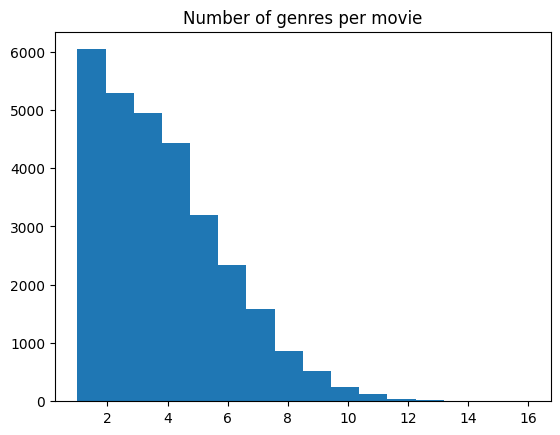

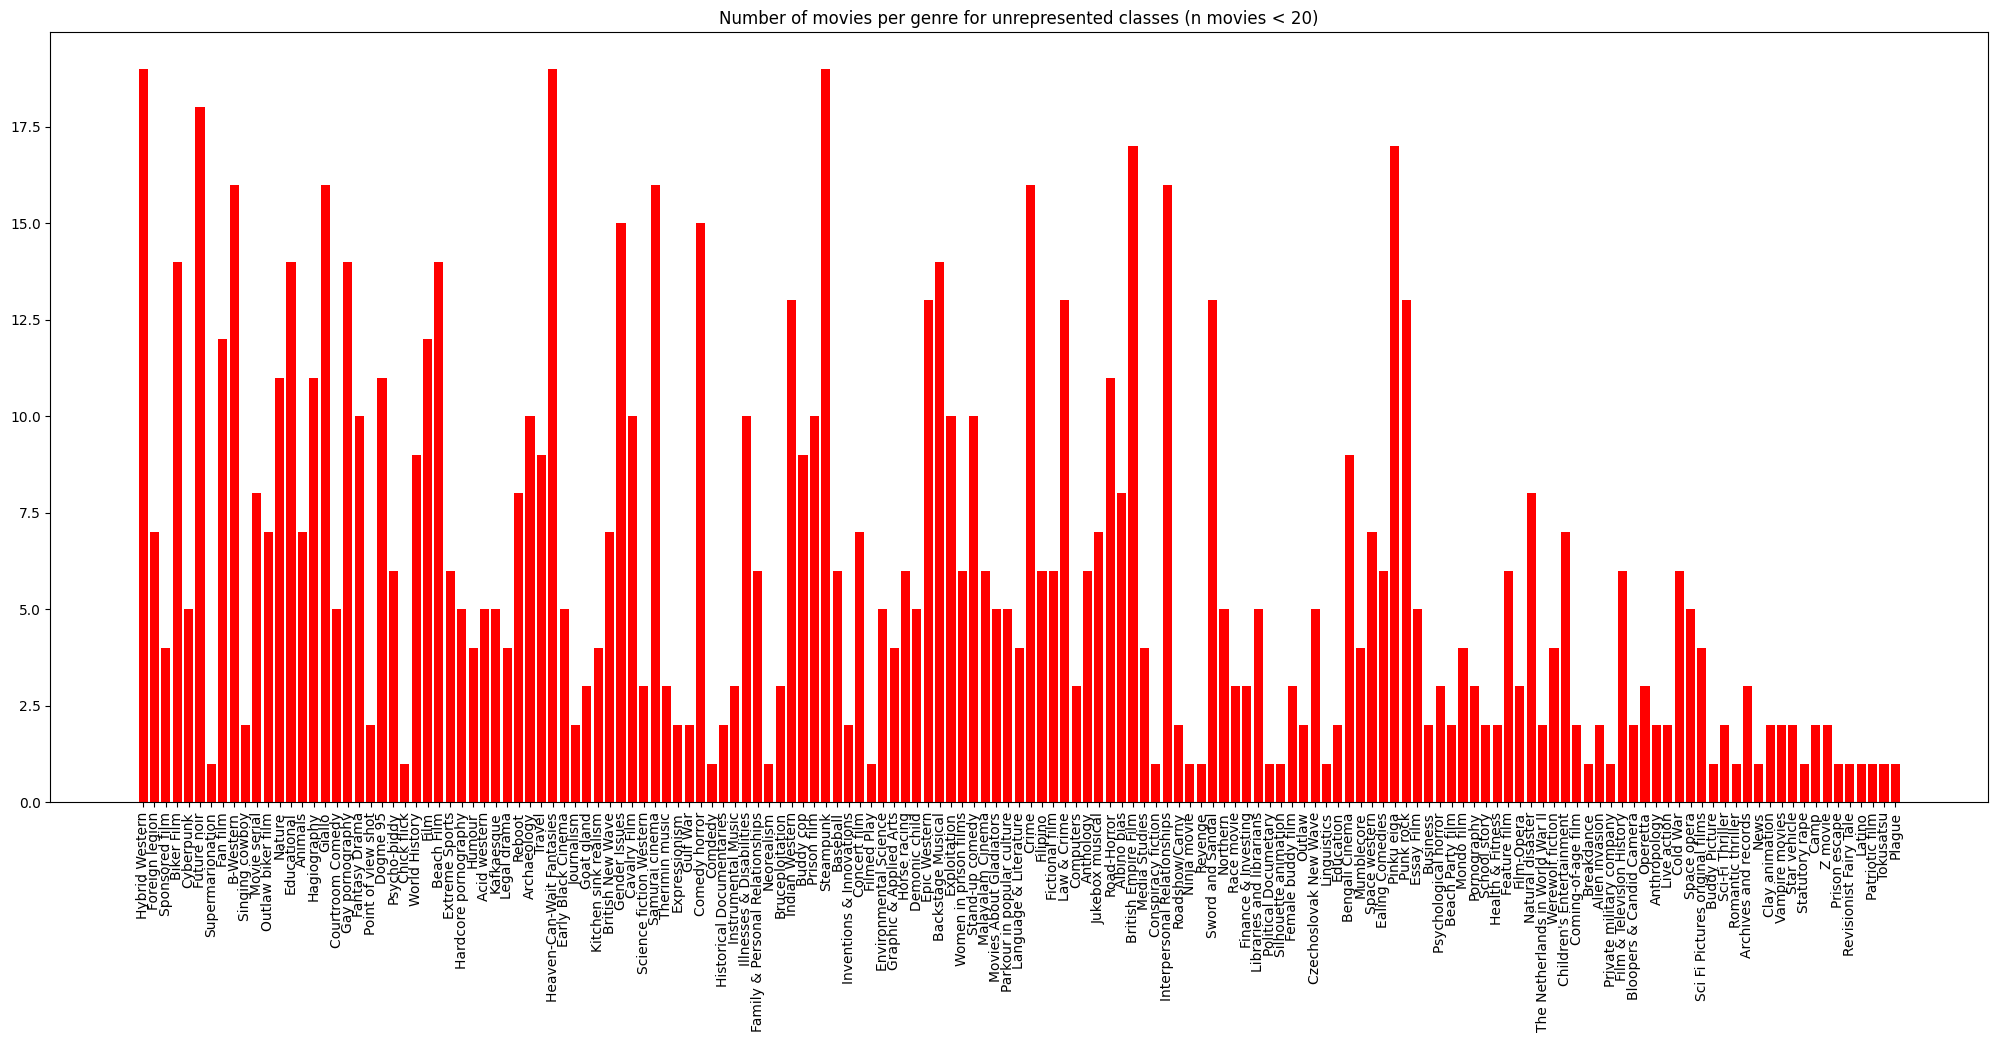

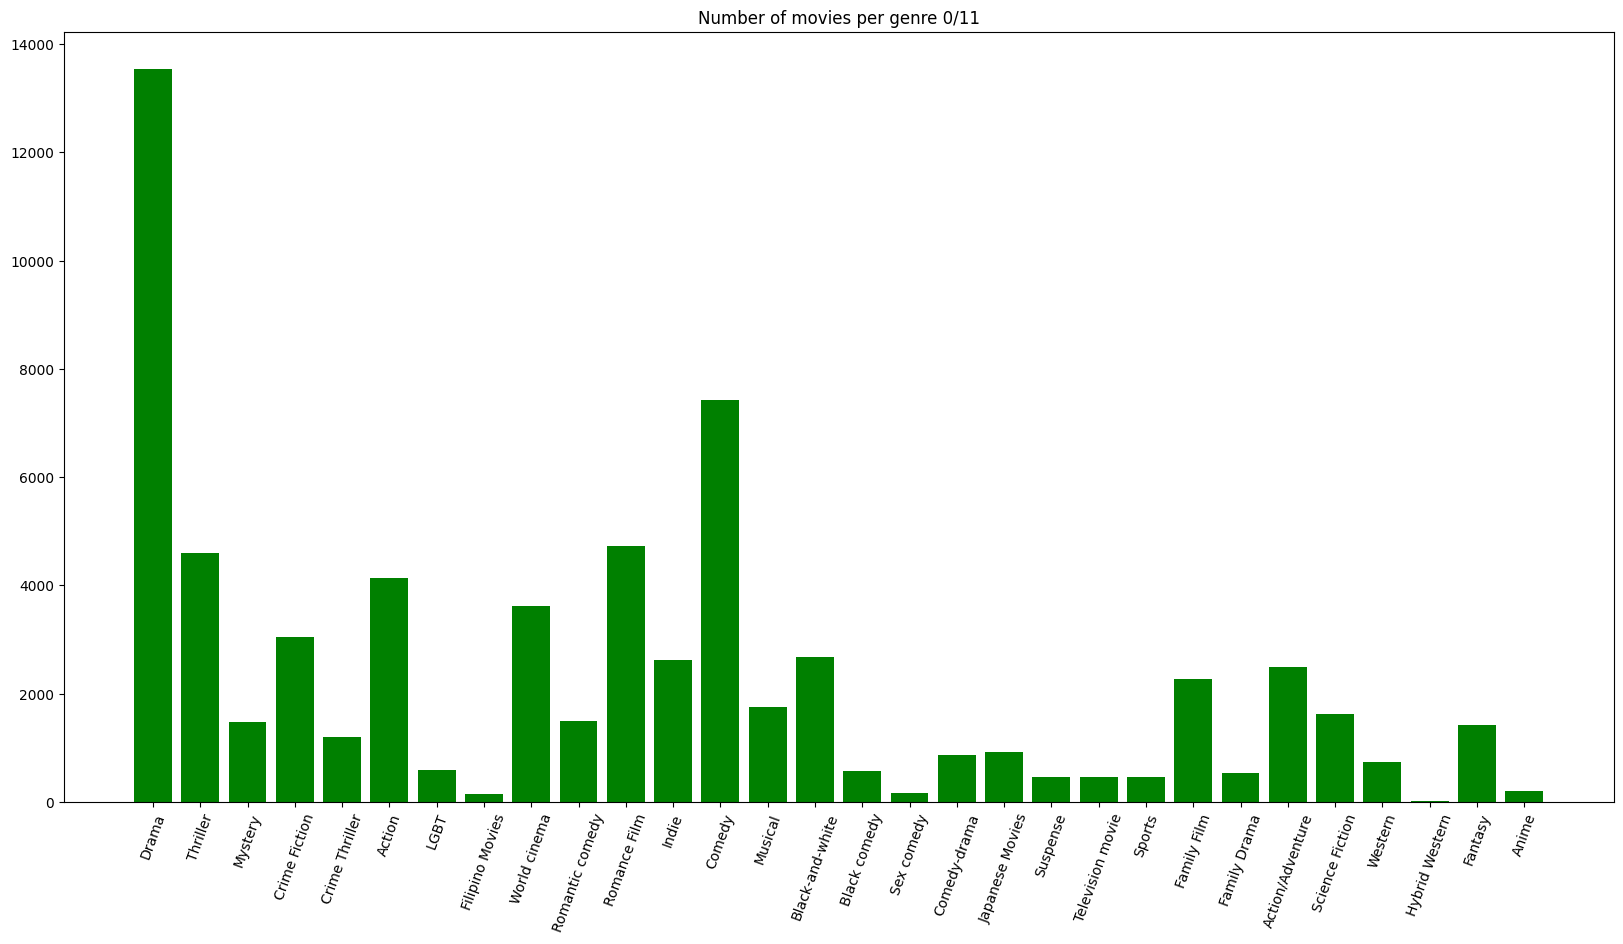

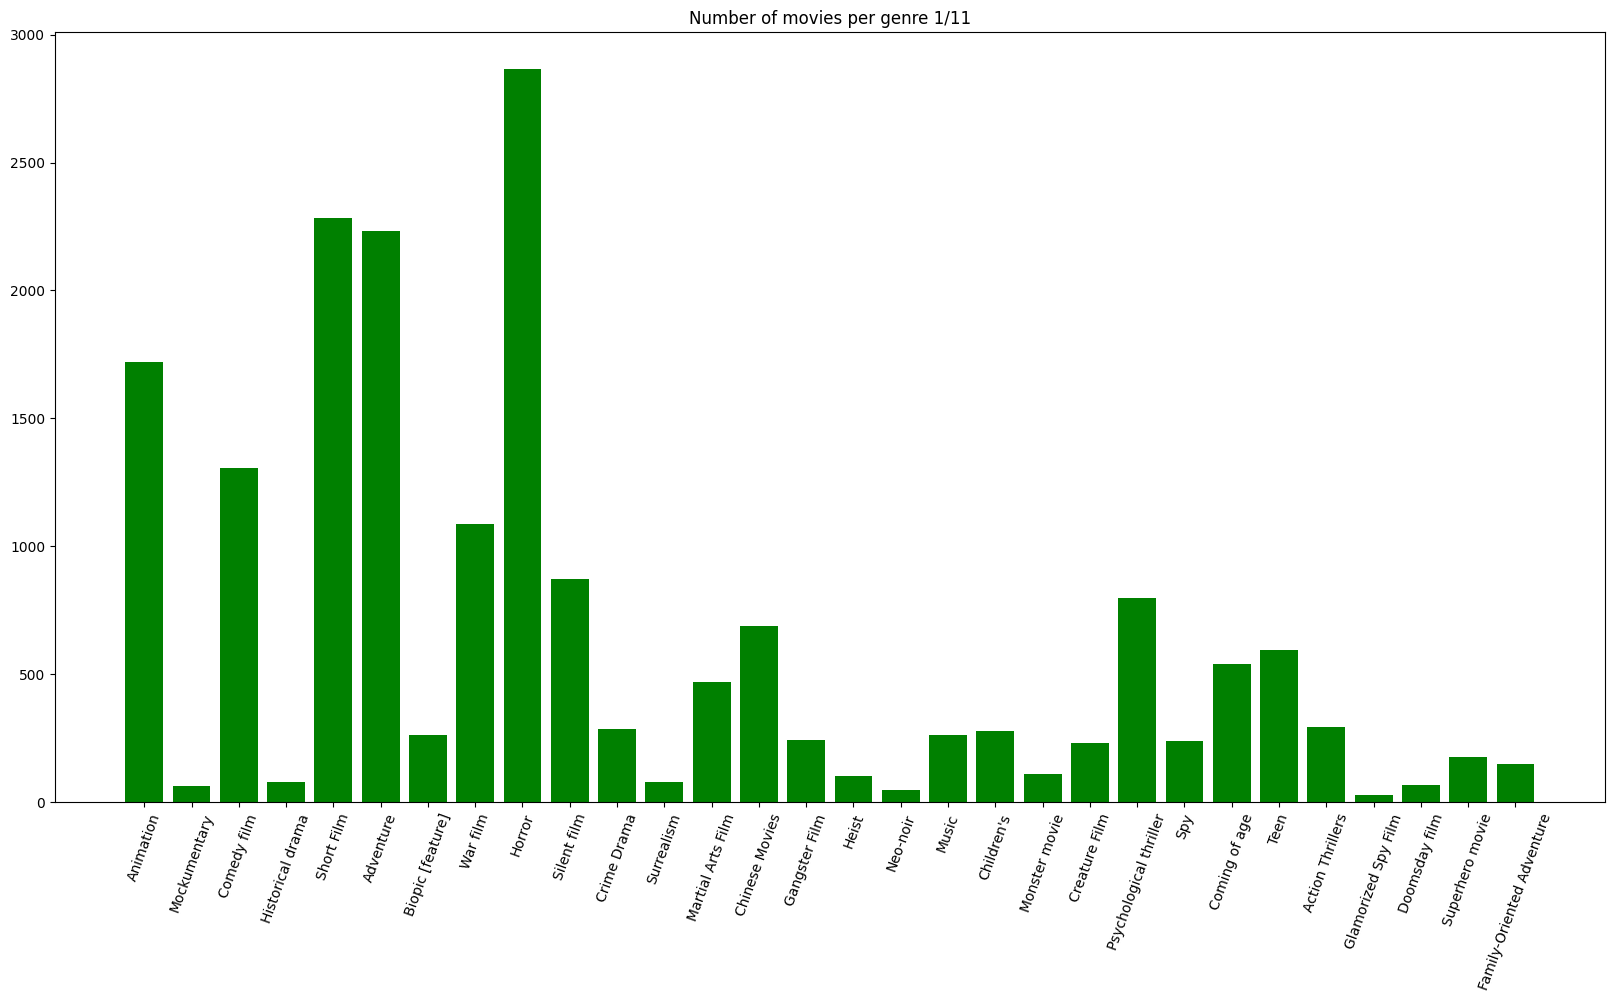

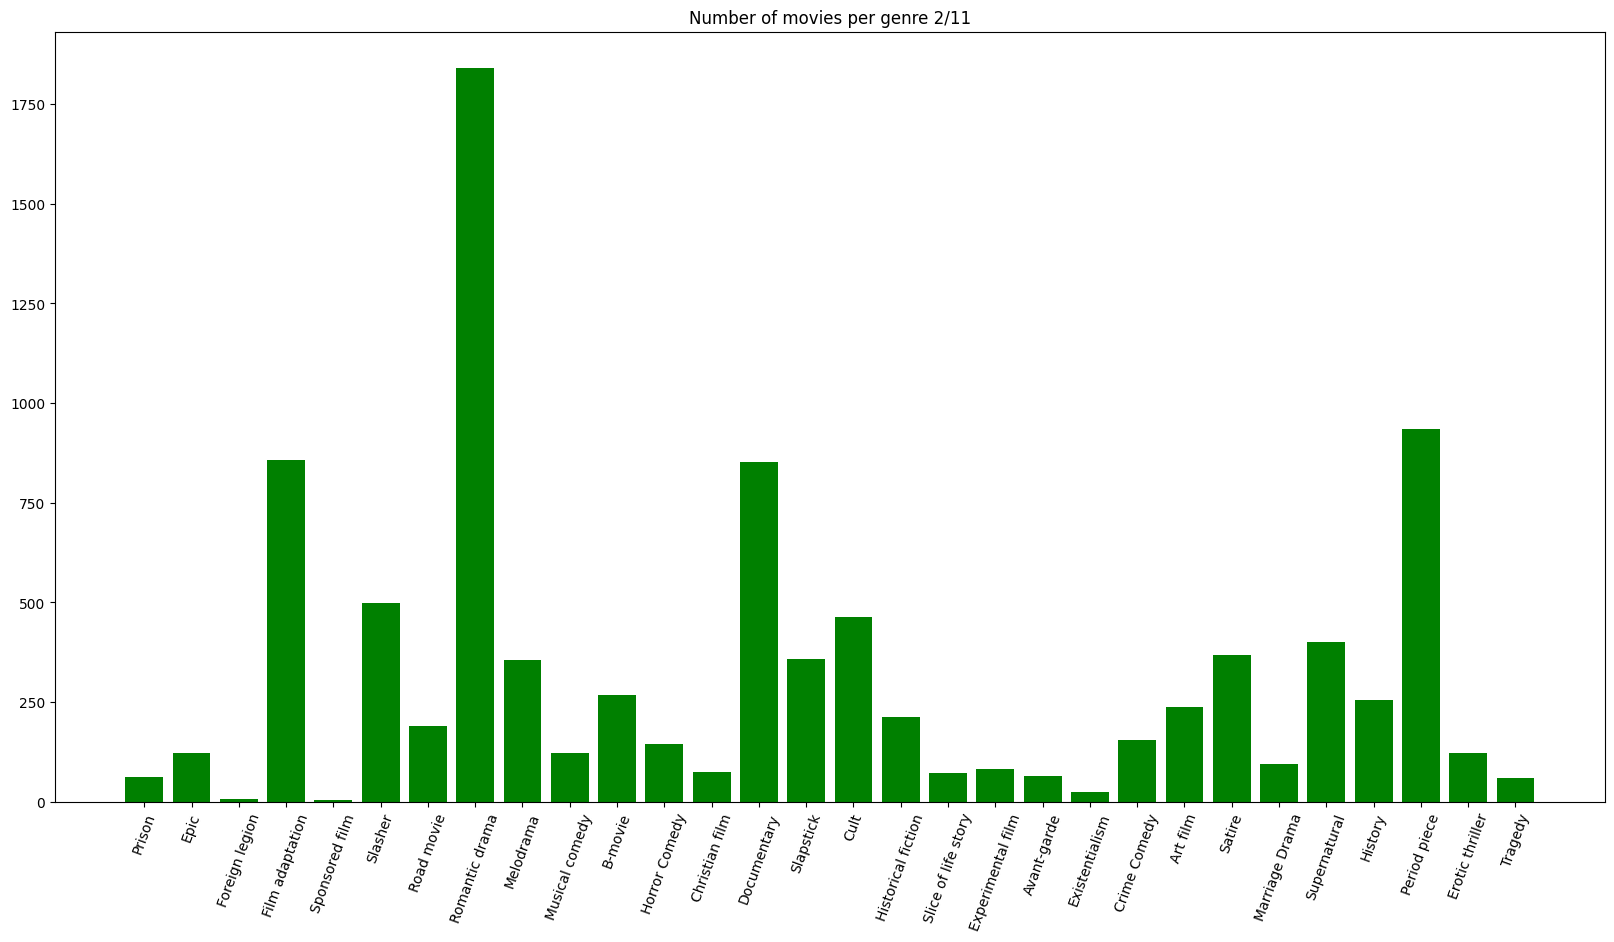

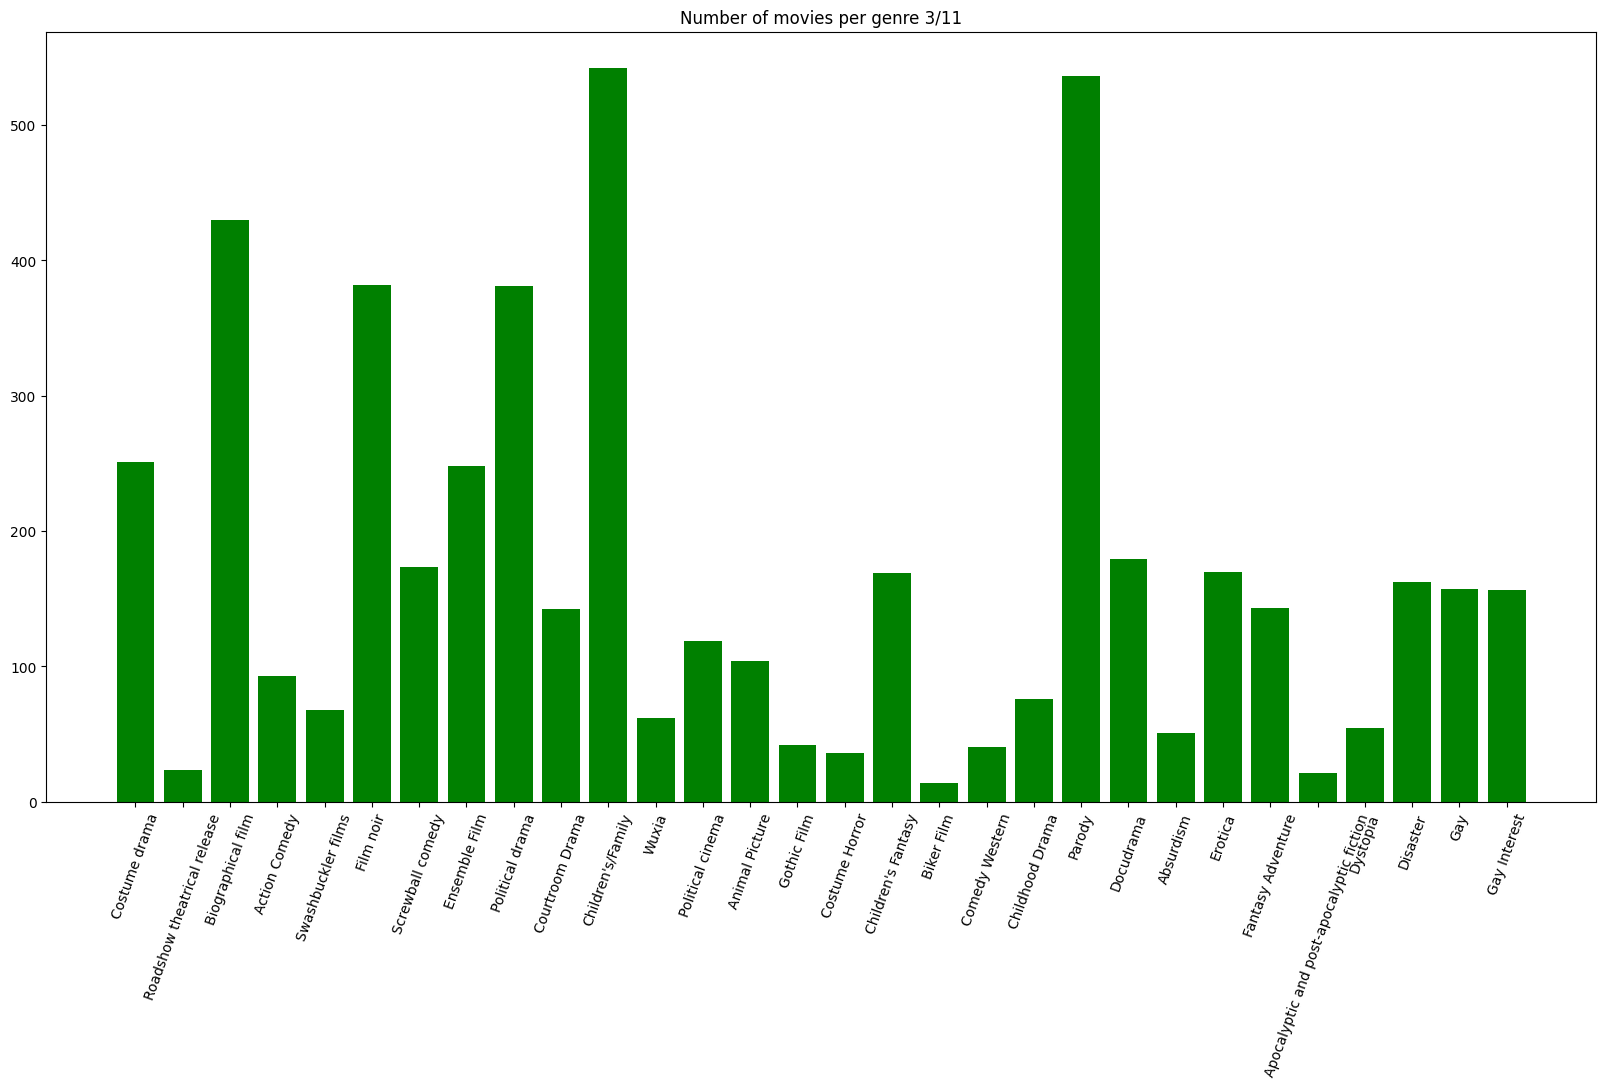

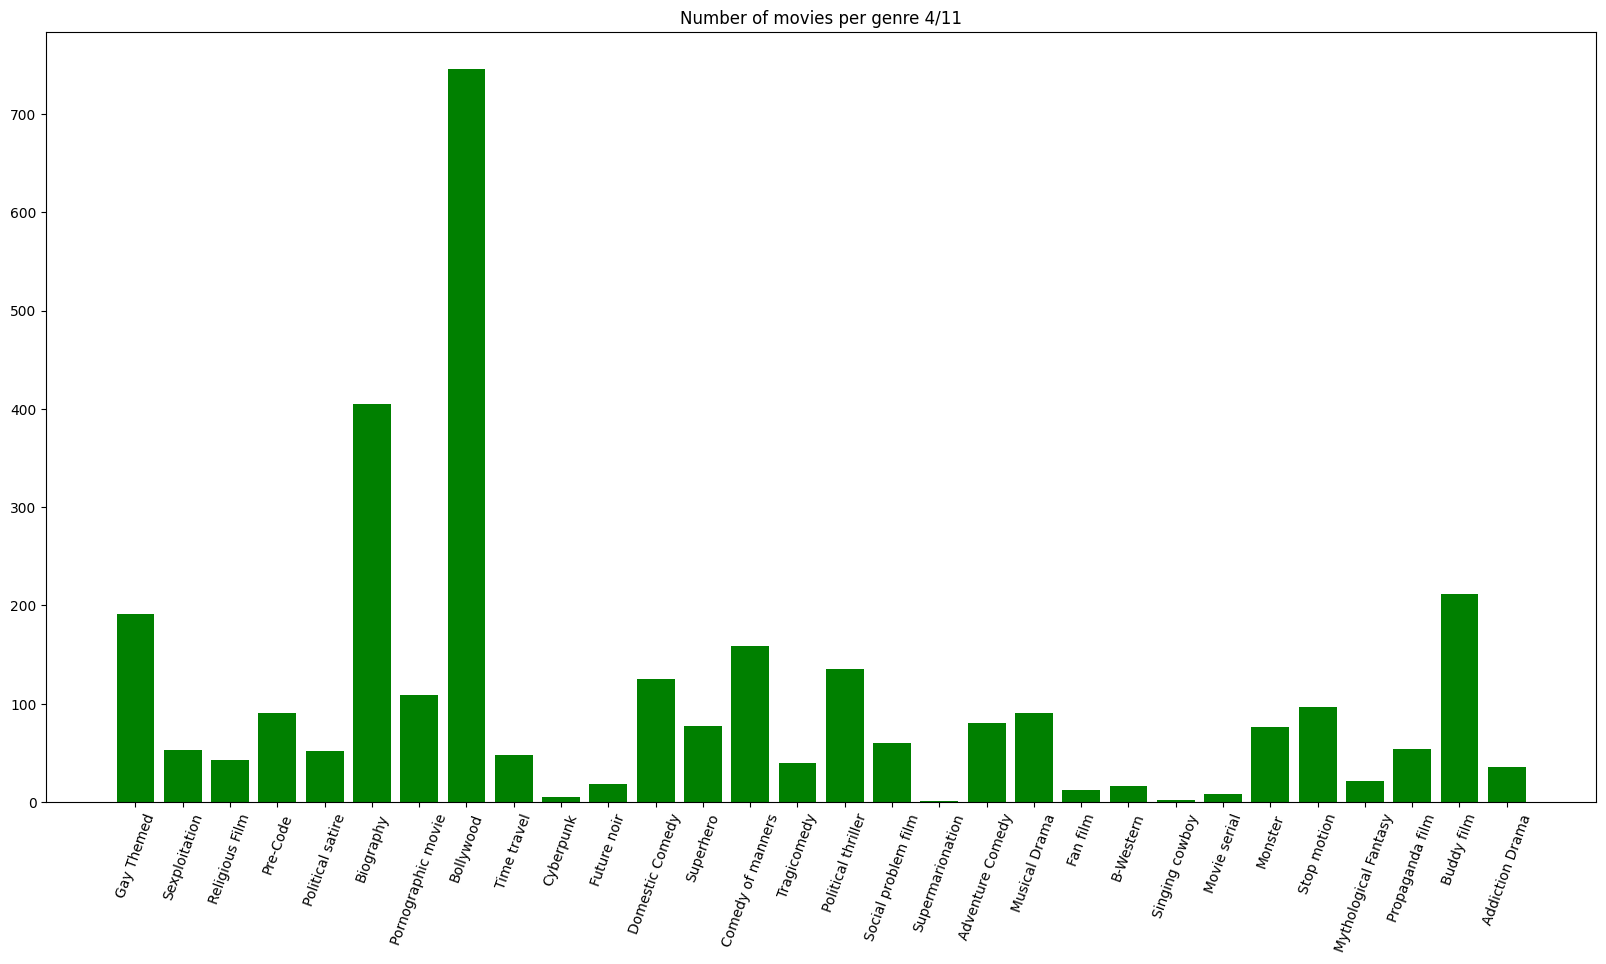

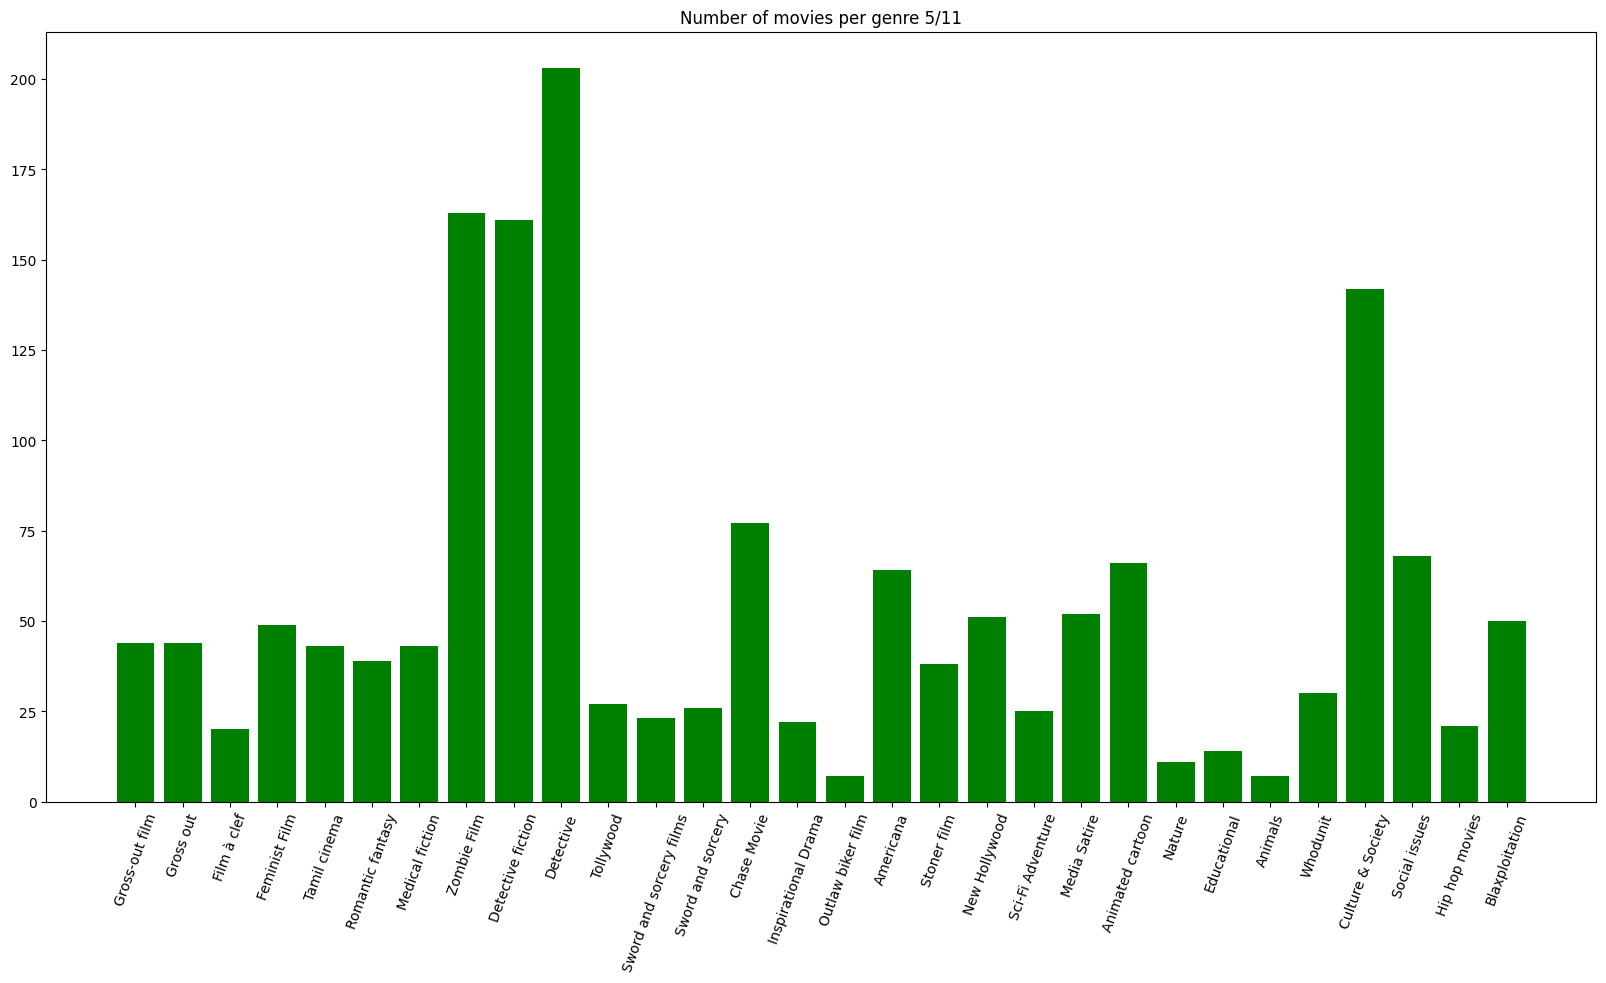

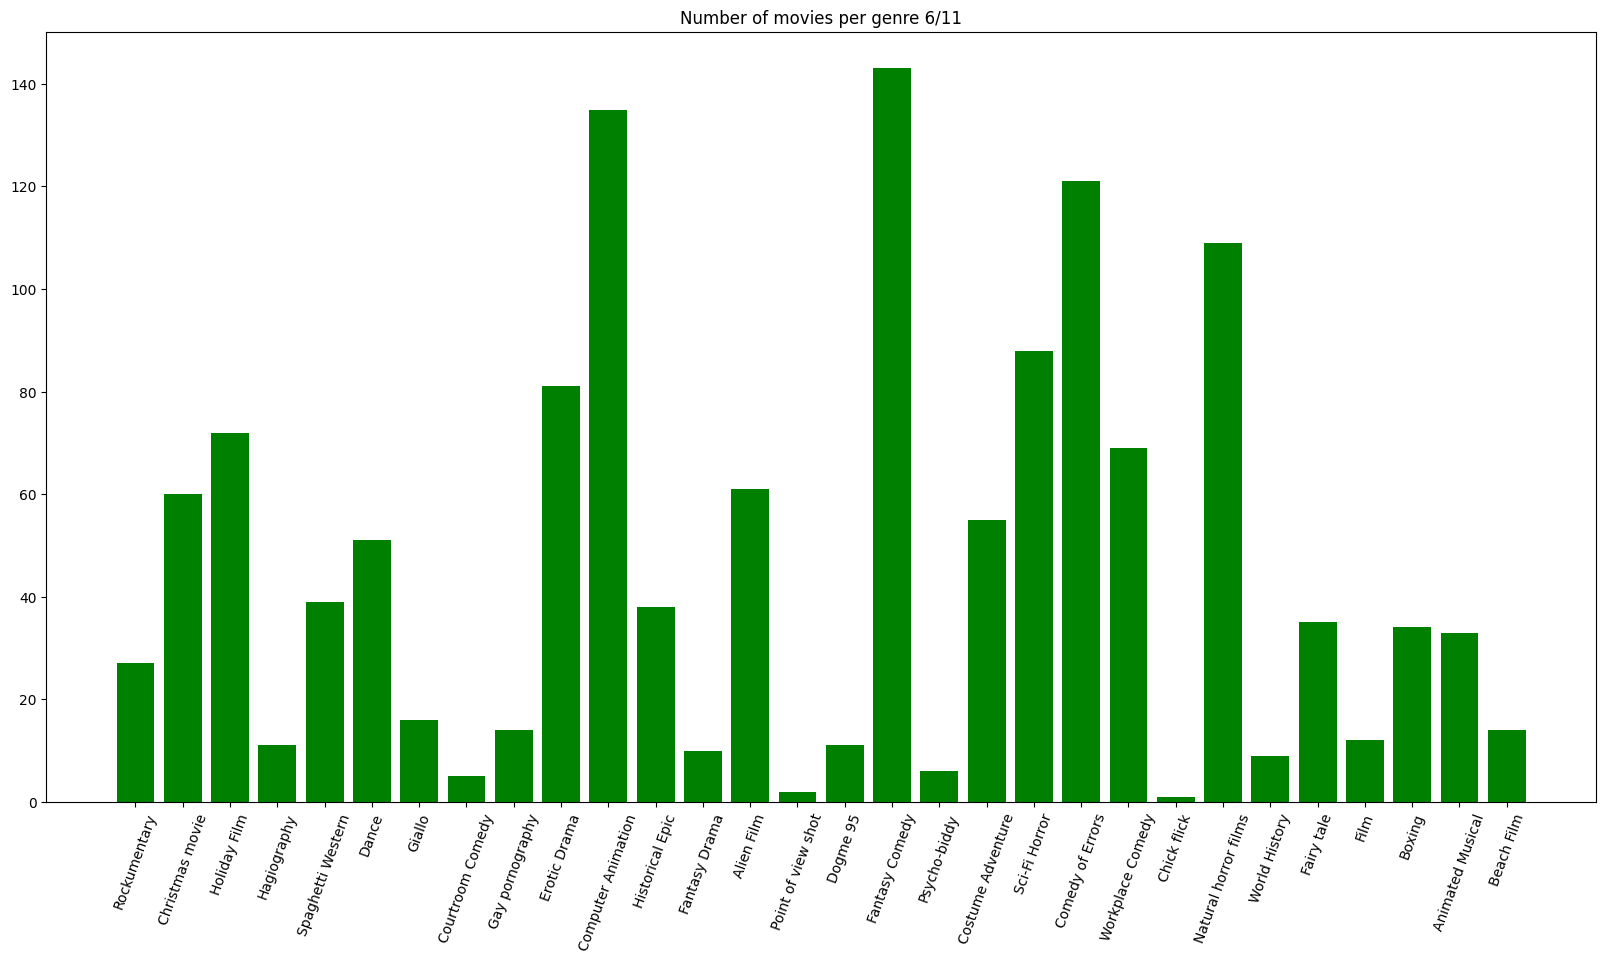

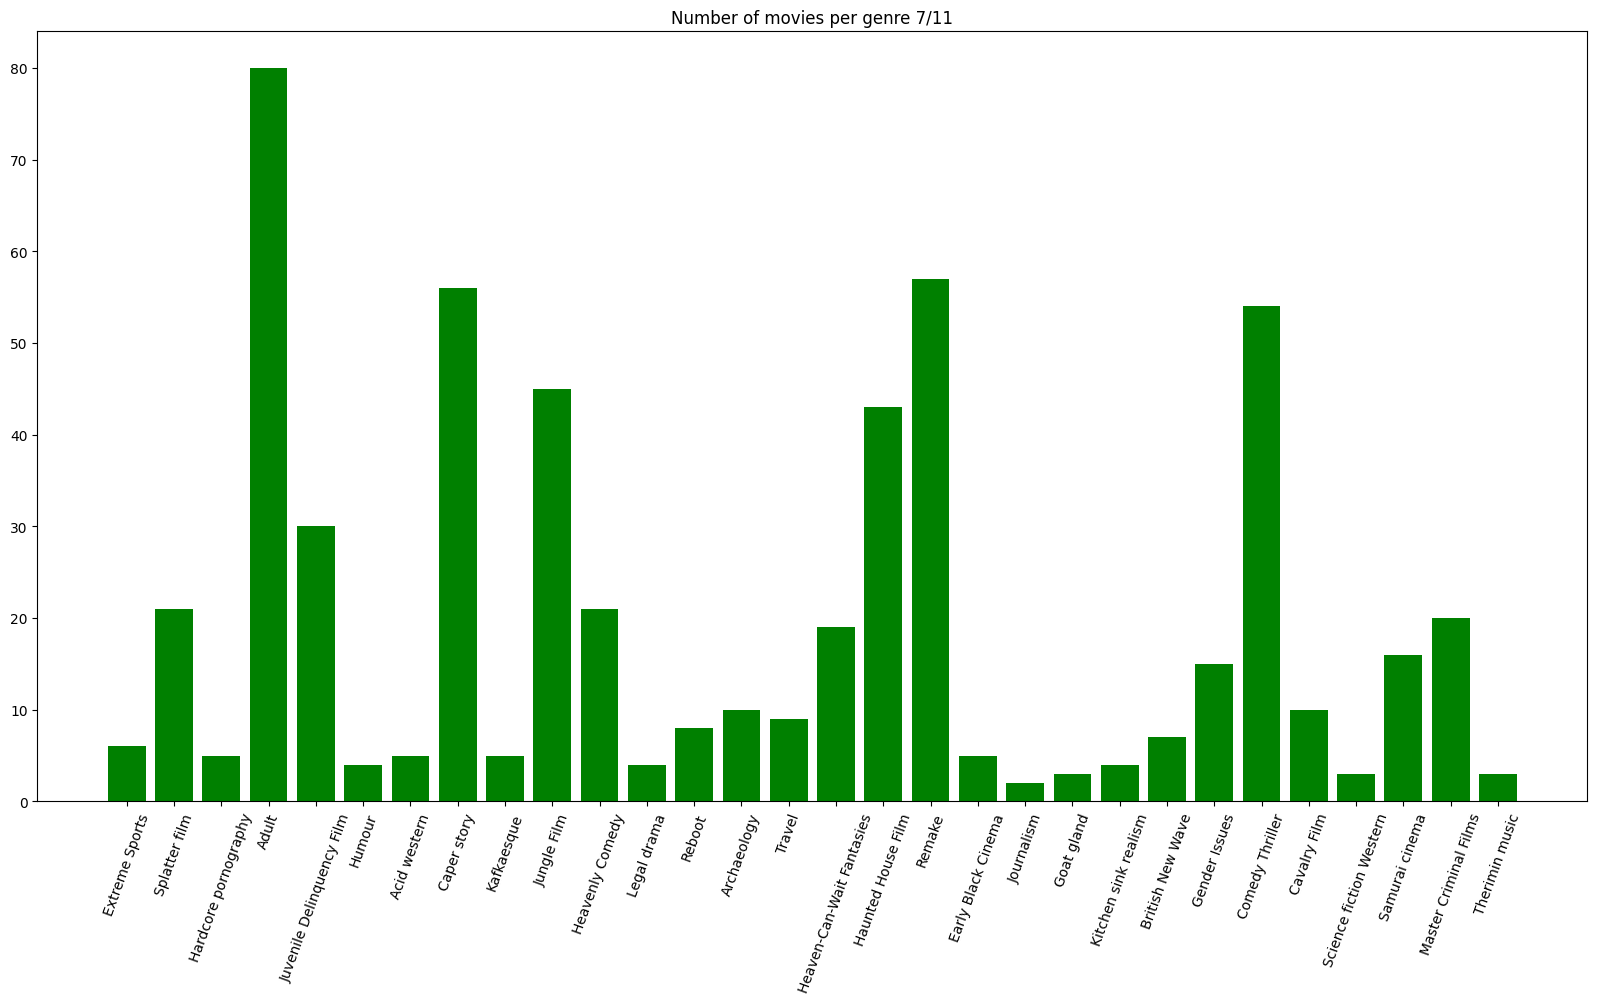

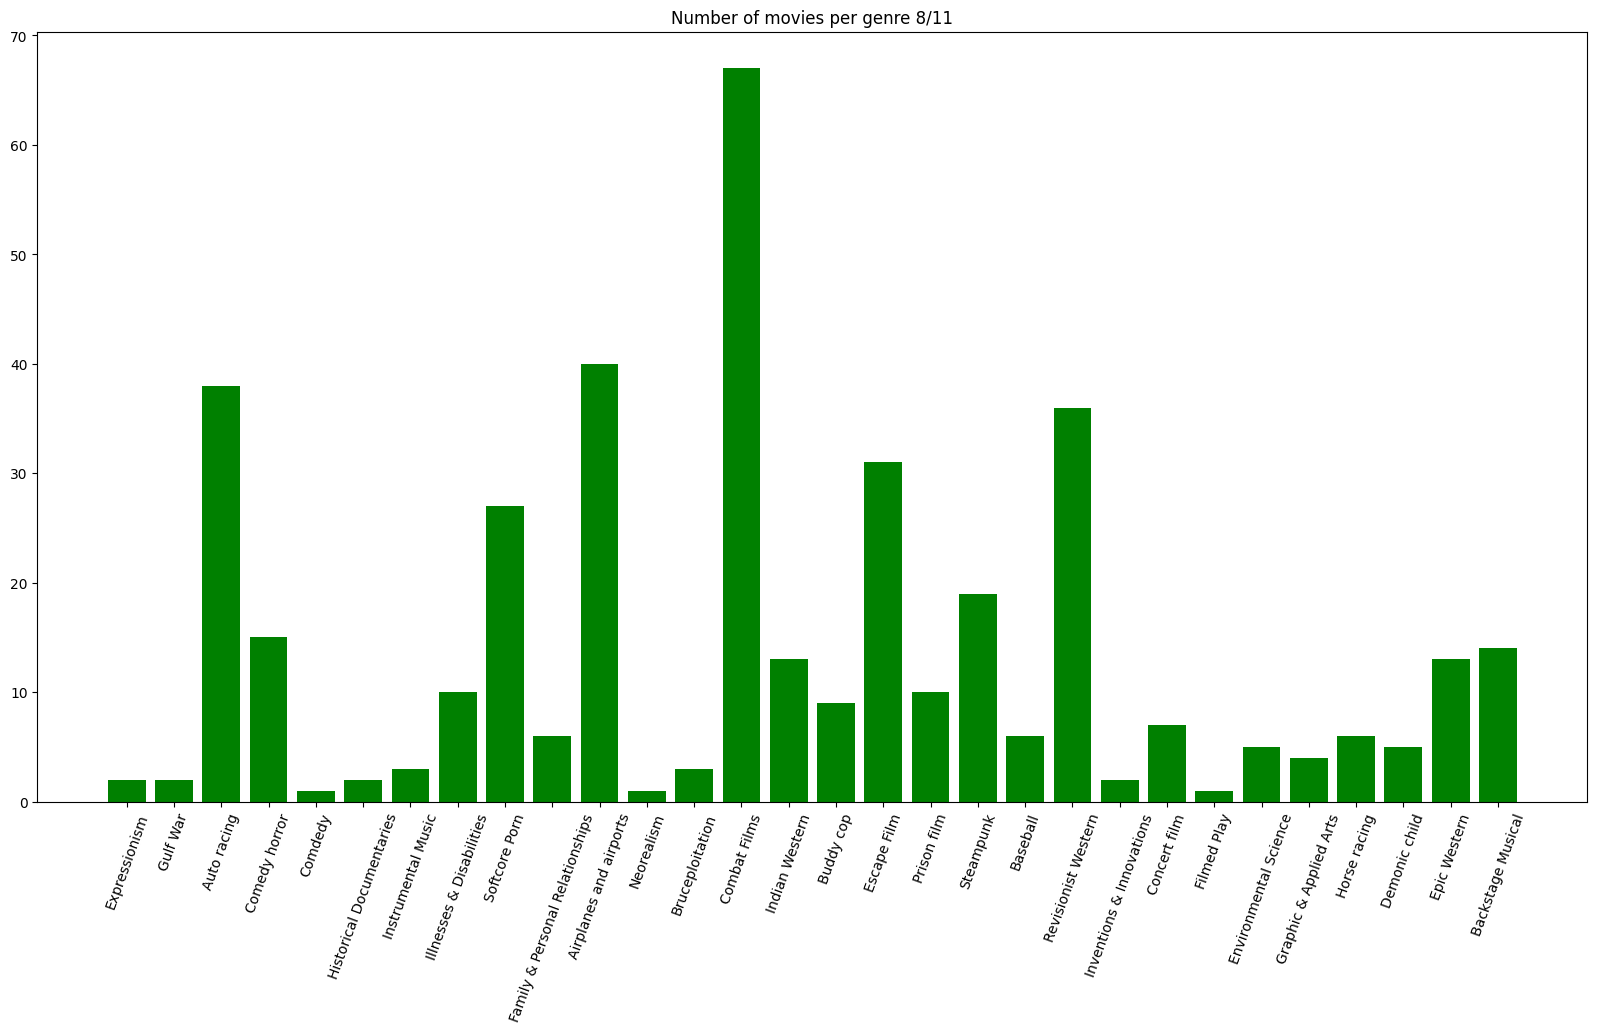

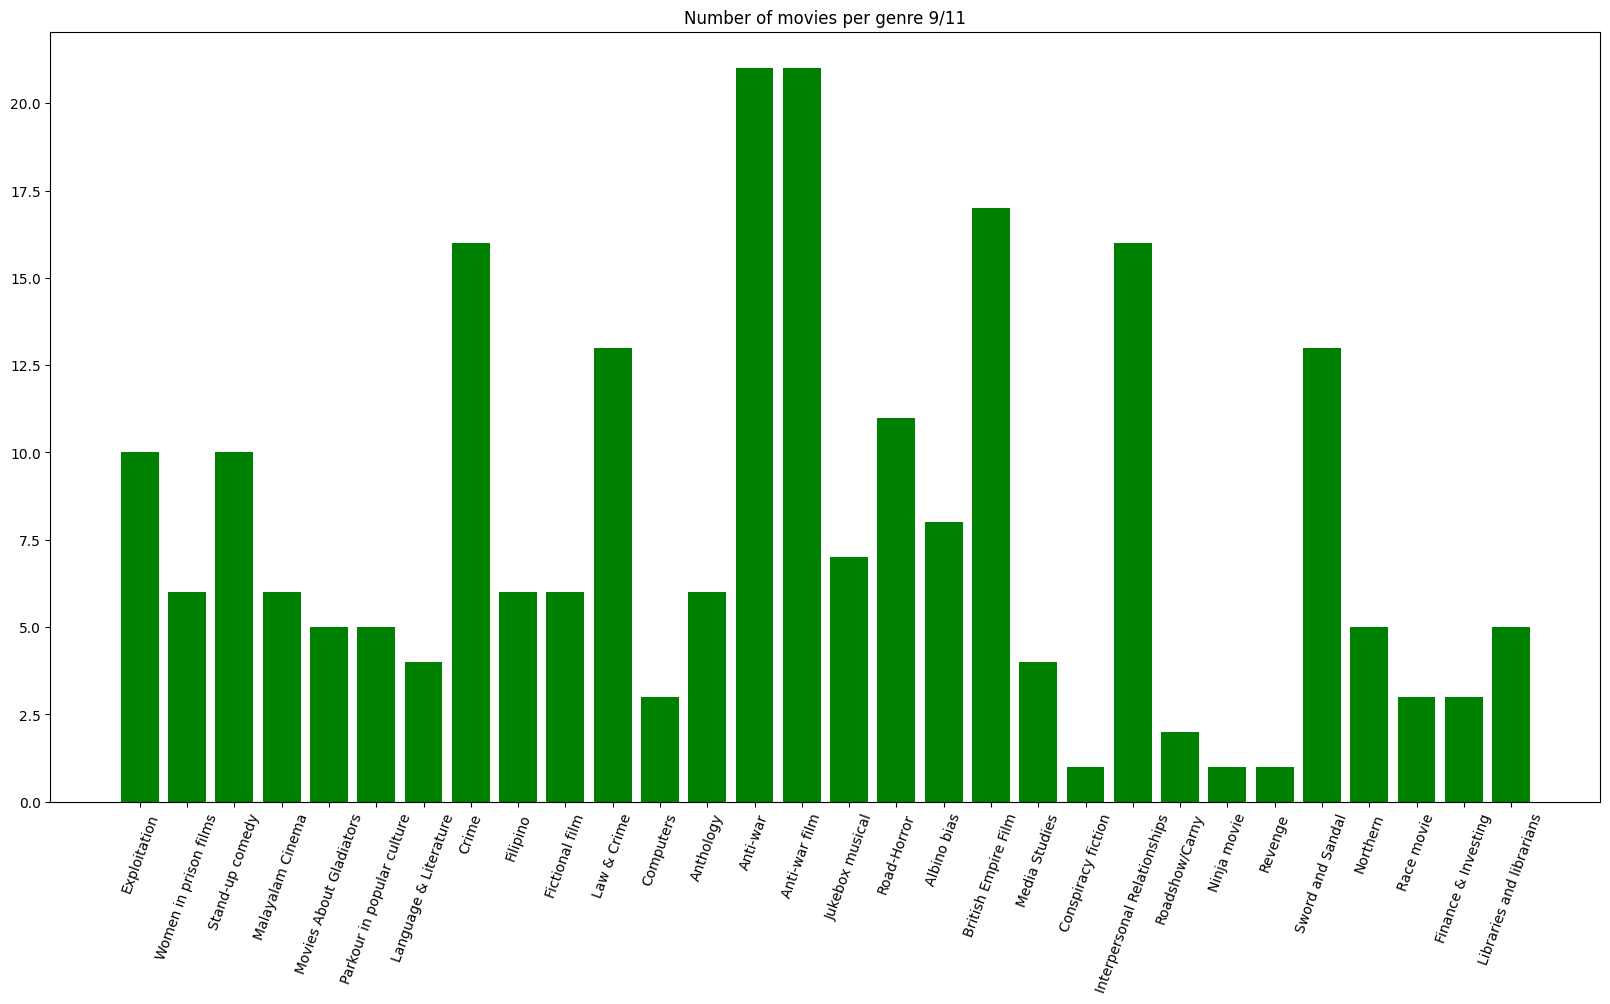

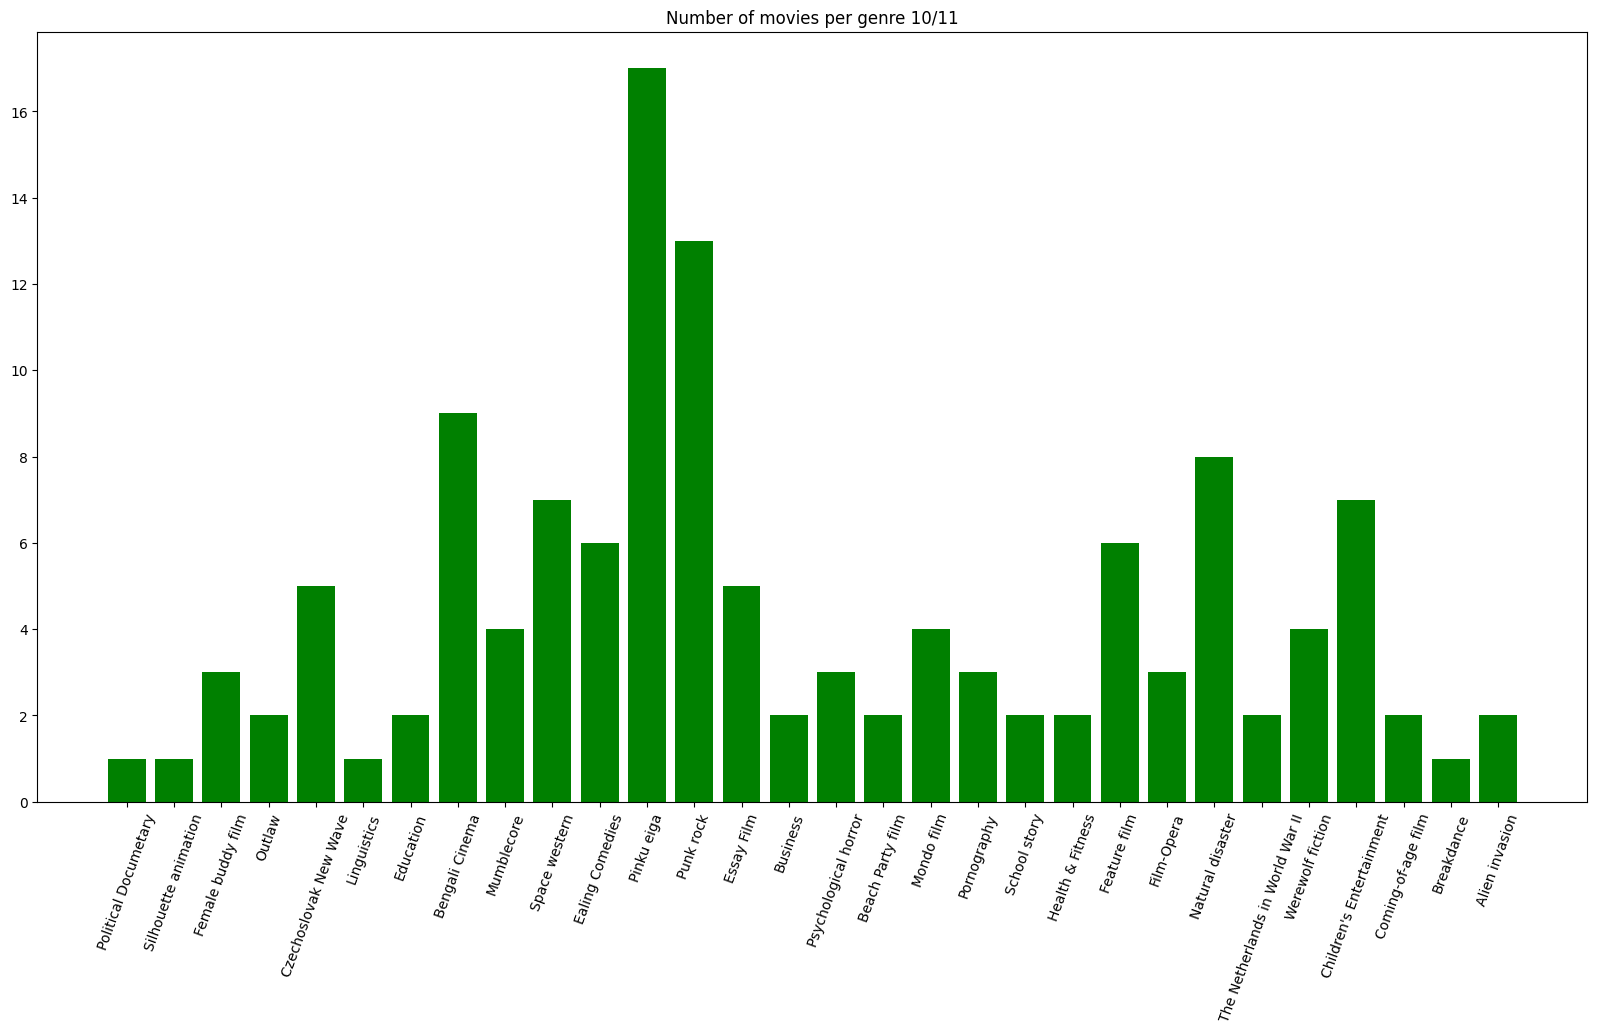

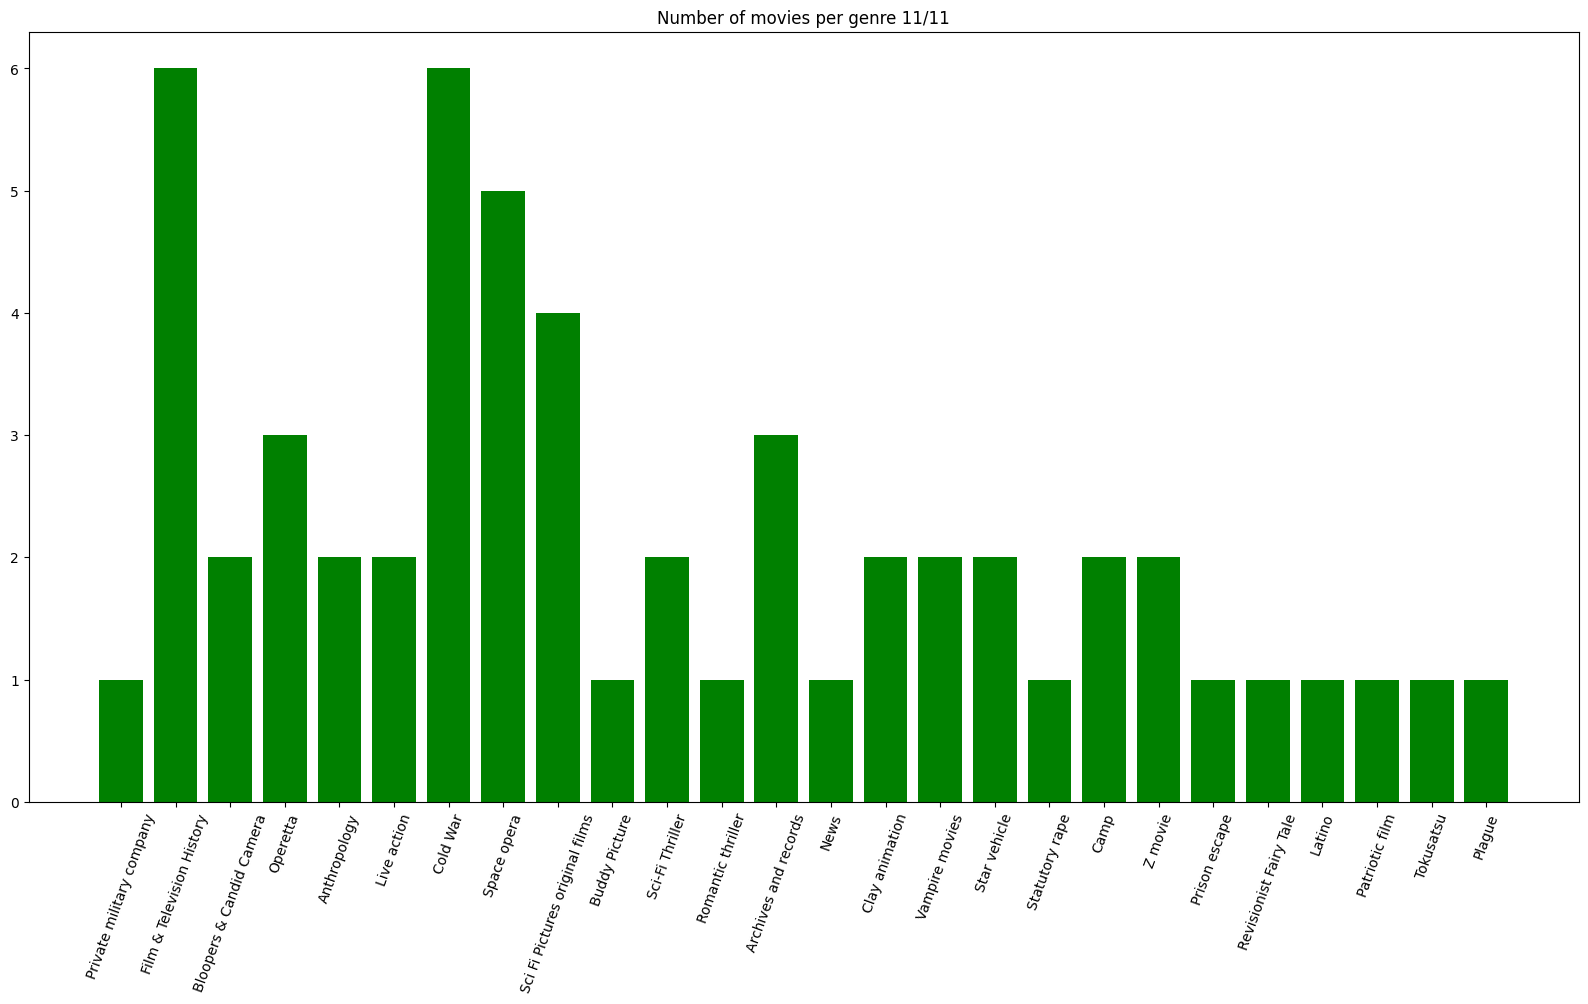

In [ ]:
plt.title("Number of genres per movie")
plt.hist(n_genres, bins=np.max(n_genres))
plt.show()

keys = list(genres_summary.keys())
values = list(genres_summary.values())

unrep_keys, unrep_values = [], []
thr = 20
for k,v in zip(keys, values):
    if v<thr:
        unrep_keys.append(k)
        unrep_values.append(v)
    
plt.figure(figsize=(25,10))
plt.title(f"Number of movies per genre for unrepresented classes (n movies < {thr})")
plt.bar(unrep_keys, unrep_values, color='r')
plt.xticks(rotation=90)
plt.show()

plot_batch = 30
for i in range(len(keys)//plot_batch+1):
    plt.figure(figsize=(20,10))
    plt.title(f"Number of movies per genre {i}/{len(keys)//plot_batch}")
    plt.bar(keys[i*plot_batch: i*plot_batch+plot_batch], values[i*plot_batch: i*plot_batch+plot_batch], color='g')
    plt.xticks(rotation=70)
    plt.show()

<h2> Baseline </h2>

We chose to take a very straight-forward baseline : TF-IDF with a SGD classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from typing import Any

class BaselineModel:
    """
    This class serves as a baseline model for part 1 of the project. 
    It uses a TfidfVectorizer and an SGDClassifier to classify text data into 
    multiple classes.
    """

    def __init__(self, max_df=0.8, max_features=1000, ngram_range=(1,3)):
        """
        Initializes the BaselineModel class with its vectorizer and classifier.

        Args:
        - max_df (float, optional): When building the vocabulary, ignore terms that have a document frequency strictly higher
            than the given threshold (corpus-specific stop words). Default is 0.8.
        - max_features (int, optional): If not None, build a vocabulary that only consider the top max_features ordered
            by term frequency across the corpus. Default is 1000.
        - ngram_range (tuple, optional): The lower and upper boundary of the range of n-values for different n-grams to
            be extracted. Default is (1,3).
        """
        self.tfidf_vectorizer = TfidfVectorizer(
            max_df=max_df, max_features=max_features, ngram_range=ngram_range
        )
        self.base = SGDClassifier(loss="log_loss")
        self.clf = OneVsRestClassifier(self.base)
        
    def train(self, X_train, y_train, alpha_values=[10**-5, 10**-4, 10**-3, 10**-2, 10**-1], scoring='f1_micro'):
        """
        Trains the model using the given training data and model parameters.

        Args:
        - X_train (array-like, shape (n_samples,)): The training input samples.
        - y_train (array-like, shape (n_samples, n_classes)): The training target values (multi-class or multi-label).
        - alpha_values (list of floats, optional): List of alpha values to try for GridSearchCV. Default is
            [10**-5, 10**-4, 10**-3, 10**-2, 10**-1].
        - scoring (str, optional): Scoring metric to use for GridSearchCV. Default is 'f1_micro'.
        """
        train_tfidf = self.tfidf_vectorizer.fit_transform(X_train)
        parameters = {'estimator__alpha': alpha_values}
        gsv = GridSearchCV(self.clf, param_grid=parameters, scoring=scoring, n_jobs=-1, verbose=1)
        gsv.fit(train_tfidf, np.array(y_train))
        self.model: Any = gsv.best_estimator_
        
    def predict(self, X_test):
        """
        Predicts the labels for the given test data.

        Args:
        - X_test (array-like of shape (n_samples,))
            The proportion of the data to use for the test set (default: 0.2).

        Returns:
        - predictions: (array-like of shape (n_samples, n_classes))
            The predicted labels for the test data.
        """
        test_tfidf = self.tfidf_vectorizer.transform(X_test)
        return self.model.predict(test_tfidf)
    
    def predict_proba(self, X_test):
        """
        Predicts the probability of each label for the given test data.

        Args:
        - X_test (array-like of shape (n_samples,))
            The proportion of the data to use for the test set (default: 0.2).

        Returns:
        - predictions: (array-like of shape (n_samples, n_classes))
            The predicted labels for the test data.
        """
        test_tfidf = self.tfidf_vectorizer.transform(X_test)
        return self.model.predict_proba(test_tfidf)
    
    def get_model(self):
        """
        Getter for the model
        """
        return self.model




<h2> Metrics </h2>

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt


"""
We provide a set of metrics classes
"""


class Metrics:
    def compute_metrics(self, y_pred_proba, y_true, threshold: float = 0.2):
        raise NotImplementedError()
    def get_name(self):
        raise NotImplementedError()
    def predict_binary(self, y_pred, threshold: float = 0.2):
        pred_binary = (y_pred>threshold).astype(int)
        return pred_binary

class AccuracyMetrics(Metrics):
    def compute_metrics(self, y_pred_proba, y_true, threshold: float = 0.2):
        y_pred = self.predict_binary(y_pred_proba, threshold)
        return accuracy_score(y_true, y_pred)
    def get_name(self):
        return "accuracy"

class F1Metrics(Metrics):
    def __init__(self, average='macro'):
        self.average = average

    def compute_metrics(self, y_pred_proba, y_true, threshold: float = 0.2):
        y_pred = self.predict_binary(y_pred_proba, threshold)
        return f1_score(y_true, y_pred, average=self.average)

    def get_name(self):
        return "f1-score"

class PrecisionMetrics(Metrics):
    def __init__(self, average='macro'):
        self.average = average

    def compute_metrics(self, y_pred_proba, y_true, threshold: float = 0.2):
        y_pred = self.predict_binary(y_pred_proba, threshold)
        return precision_score(y_true, y_pred, average=self.average)

    def get_name(self):
        return "precision"

class RecallMetrics(Metrics):
    def __init__(self, average='macro'):
        self.average = average

    def compute_metrics(self, y_pred_proba, y_true, threshold: float = 0.2):
        y_pred = self.predict_binary(y_pred_proba, threshold)
        return recall_score(y_true, y_pred, average=self.average)

    def get_name(self):
        return "recall"


def compute_all_metrics(X_test, y_test, model, threshold=0.2):

    y_pred = model.predict_proba(X_test)

    metrics_summary = {}
    for metrics in [PrecisionMetrics(), 
                    RecallMetrics(), 
                    F1Metrics(), 
                    AccuracyMetrics(),]:
        metrics_summary[metrics.get_name()] = metrics.compute_metrics(y_pred, y_test, threshold=threshold)
        
    return metrics_summary


def compute_roc_auc(X_test, y_test, model, plot=True):
    y_score = model.predict_proba(X_test)
    n_classes = len(y_test[0])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    print(n_classes)
    for i in tqdm(range(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    if plot:
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"], label='ROC curve micro (area = %0.2f)' % roc_auc["micro"])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    optimal_threshold = find_best_threshold(fpr["micro"], tpr["micro"], roc_auc["micro"])
    return fpr, tpr, roc_auc, optimal_threshold

def find_best_threshold(fpr, tpr, thresholds):
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

<h2> Flow representation </h2>

In [ ]:
class Flow:
    """
    The assignment was to do the prediction inside a single class. 
    This class was designed to perform all the steps, using all the previous
    classes
    """
    def __init__(self, data_loader, model, trained_model=False):
        self.data_loader = data_loader
        self.model = model
        self.trained_model = trained_model
        self.prepare_data()

    def prepare_data(self) -> None:
        self.X_train, self.X_test, self.y_train, self.y_test = self.data_loader.provide_train_test_data()

    def train(self):
        if self.trained_model:
            print("The model is already trained, skipping training step")
            return
        self.model.train(self.X_train, self.y_train)
        # get rid of the training log once it stops training not to overload the notebook display
        clear_output() 
        self.trained_model = True

    def test(self, threshold=0.2):
        if not self.trained_model:
            print("The model is not trained, the testing is not possible.")
            return
        if threshold is None:
            fpr, tpr, roc_auc, threshold = compute_roc_auc(self.X_test, 
                                                    self.y_test, 
                                                    self.model, 
                                                    plot=True)
        metrics = compute_all_metrics(self.X_test, 
                                   self.y_test, 
                                   self.model, 
                                   threshold)
        return metrics

    def predict_genres(self, movie_plots: List[str], threshold=0.2):
        """
        Predicts the movie genres for a list of movie plots and prints the results.
        
        Args :
        - movie_plots (List[str])
            A list of movie plots to predict genres for.
        - threshold (float)
            The probability threshold for a genre to be considered as predicted.
        
        
        Prints:
            For each movie plot in the input list, prints the movie plot and 
            the predicted genres along with their probabilities in the format 
            "Genre (Probability%)" sorted in descending order
            of probability.
        """

        if not self.trained_model:
            print("The model is not trained, the testing is not possible.")
            return
        y_probas = self.model.predict_proba(movie_plots)
        y_binary = (y_probas>threshold).astype(int)

        y_genres = self.data_loader.mlb.inverse_transform(y_binary)

        for genre_probas, movie_plot, genres in zip(y_probas, movie_plots, y_genres):
            genre_high_probas = [p for p in genre_probas if p>threshold]
            genre_prob_pairs = list(zip(genres, genre_high_probas))
            genre_prob_pairs.sort(key=lambda x: x[1], reverse=True)

            genre_prob_str = ""
            for pair in genre_prob_pairs:
                genre_prob_str += f"{pair[0]} ({int(pair[1]*100)}%), "
            genre_prob_str = genre_prob_str[:-2] # remove trailing coma

            print(movie_plot)
            print(genre_prob_str)
            print("-"*10)


In [ ]:
baseline_flow = Flow(data_loader=MovieDataLoaderBaseline("train.json"),
                     model=BaselineModel(max_features=20000),
                     )

In [ ]:
baseline_flow.train()
baseline_flow.test()

In [ ]:
my_movie_plots = [
    "A princess with long, magical hair is locked away in a tower by an evil witch. When a thief stumbles upon her tower, she convinces him to help her escape and embark on an adventure.",
    "A young boy is accidentally left behind when his family goes on vacation for Christmas. He must defend his home from two burglars using a series of booby traps and tricks.",
    "A cyborg assassin is sent back in time from the future to kill the mother of the future leader of the human resistance. A soldier is also sent back in time to protect her and stop the assassin.",
    "An epic space opera follows the adventures of a farm boy who becomes a Jedi Knight and fights against the evil Empire led by a dark lord. Along the way, he teams up with a smuggler, a princess, and other allies to save the galaxy."
]
threshold = 0.2
baseline_flow.predict_genres(my_movie_plots, threshold)

<h2> Optimizing with data cleaning </h2>

Find a solution for classes with very few examples (called few-data classes in the rest of the code)

Here are the solutions I imagined for addressing the issue. 

1. **Merging the few-data classes to more represented classes.** <br>
I thought about it because a few classes are either very specific genres (Gulf War could be merged with Historical Movie for example) or are separated from the well-represented class for a given reason (`Comdedy` genre is a typo and should be merged to `Comedy`, or two genres are split though they are very close, such as `Prison` and `Prison Escape`)

2. **Deleting the few-data classes** <br>
This is actually not a way to avoid the issue. I think that, when a movie has a genre hardly represented, it may also have more genres. Then, deleting these genres does not hurt the model as these genres can't represent a movie on their own. 

3. **Restrincting the few-data classes to the training set** <br>
This is a softer way to address the issue than the last solution. We keep the classes, but we know we can't learn enough to test them efficiently. Then, all the movies with these classes will be located in the training set.

4. **Annotating by hand** <br>
This is definitely the best solution for our problem. Indeed, the number of few-data classes is quite low (~150), so it would not take much time to link those classes to other more represented classes manually, as we suggest in the solution 1. We would also know easily which classes are too specific and should be ignored. In this assignment I will not do it as it would not bring a lot of value to my work, however I feel it is very important to highlight that this is a totally viable solution given the reduced size of problematic classes. 


-------------------------------------------------------------------

<h3> Solutions implemented in the code </h3>

The solution 1. will be implemented thanks to Levenshtein similarity score. We will address the issue of the viability of this kind of solution. Also the 2. will be implemented as well : we delete the genre in the case the movie has more genres as well, and if the movie has only rare genres, we will delete the movie as the genre will be hardly predictable.




In [ ]:
from collections import defaultdict
import Levenshtein

class MovieDataLoaderMergeClass(MovieDataLoaderBaseClass):
    """
    This class is a data loader that is implementing the first solution
    """
    def __init__(self, data_file_path: str, rare_genre_threshold=20):
        super().__init__(data_file_path)
        self.rare_genre_threshold = rare_genre_threshold

    def get_genres_categories(self):
        count_dict = defaultdict(int)  
        for movie_data in self.data:
            for genre in movie_data["genres"].values(): 
                count_dict[genre]+=1

        frequent_genres = [genre for genre, occurrences in count_dict.items() if occurrences > self.rare_genre_threshold]
        rare_genres = [genre for genre, occurrences in count_dict.items() if occurrences <= self.rare_genre_threshold]
        return (frequent_genres, rare_genres)

    def clean_genre(self, genre):
        genre = genre.lower()
        genre = genre.replace("-", "")

        words_to_remove = ["film", "cinema", "films", "movies"]
        genre_words = genre.split()
        genre_words = [word for word in genre_words if word not in words_to_remove]

        cleaned_genre = " ".join(genre_words)
        return cleaned_genre

    def find_closest_genre(self, frequent_genres, rare_genres, accept_threshold=0.8):
        """
        Uses Levenshtein distance to match rare genres to frequent genres
        """
        result = {}
        for e1 in rare_genres:
            closest_element = None
            closest_score = 0
            for e2 in frequent_genres:
                score = Levenshtein.ratio(self.clean_genre(e1), self.clean_genre(e2))
                if score > closest_score:
                    closest_element = e2
                    closest_score = score
            if closest_score >= accept_threshold:
                result[e1] = (closest_element, closest_score)
        return result

    def preprocess_data(self, levenshtein_based_merge:bool=True, remove_rares:bool=True) -> None:
        """
        Preprocess the loaded data by cleaning the plot summaries, creates the 
        genres list and transforms the genre labels using MultiLabelBinarizer
        """

        if self.preprocessed:
            return 

        self.genres: List = []        

        for movie_data in self.data:
            movie_data['plot_summary_clean'] = self.clean_text(movie_data["plot_summary"])
            self.genres.append(list(movie_data["genres"].values()))

        frequent_genres, rare_genres = self.get_genres_categories()
        if levenshtein_based_merge:
            # link rare genres to more frequent ones
            converter = self.find_closest_genre(frequent_genres, rare_genres, accept_threshold=0.9)
            self.genres = [[converter[genre][0] if genre in converter.keys() else genre for genre in genre_list] for genre_list in self.genres]

        if remove_rares:
            new_genres = []
            new_data = []
            for i in range(len(self.genres)):
                genres = self.genres[i]
                rare_genres_present = set(genres).intersection(set(rare_genres))

                if not rare_genres_present:
                    new_genres.append(genres)
                    new_data.append(self.data[i])
                elif len(rare_genres_present) < len(genres):
                    new_genres.append(list(set(genres) - rare_genres_present))
                    new_data.append(self.data[i])
                else:
                    continue
            self.data = new_data
            self.genres = new_genres


        self.mlb = MultiLabelBinarizer()
        self.genres_encoded = self.mlb.fit_transform(self.genres)
        self.preprocessed = True

    def provide_train_test_data(self, 
                                levenshtein_based_merge:bool=True, 
                                remove_rares:bool=True,
                                test_size=0.2, 
                                random_state=42):
        """
        Split the preprocessed data into training and test sets.

        Args:
        - test_size (float): The proportion of the data to use for the test set (default: 0.2).
        - random_state (int): The random seed to use for reproducibility (default: 42).

        Returns:
        - tuple: A tuple containing the training and test data and labels in the format (X_train, X_test, y_train, y_test).
        """
        self.preprocess_data(levenshtein_based_merge, remove_rares)
        X = np.array([data["plot_summary_clean"] for data in self.data])
        y = self.genres_encoded
        X_train, X_test, y_train, y_test = train_test_split(X, self.genres_encoded,
                                                            test_size=test_size, 
                                                            random_state=random_state)
        return X_train, X_test, y_train, y_test
    
    def get_data(self):
        return self.data


In [ ]:
mloader_merge = MovieDataLoaderMergeClass("train.json", rare_genre_threshold=5)
(frequent_genres, rare_genres) = mloader_merge.get_genres_categories()
closest8 = mloader_merge.find_closest_genre(frequent_genres, rare_genres, accept_threshold=0.8)
closest9 = mloader_merge.find_closest_genre(frequent_genres, rare_genres, accept_threshold=0.9)

In [ ]:
for old, new in closest8.items():
    print(f"{old} -> {new[0]} with score {round(new[1],2)}")
print(len(closest9.keys())/len(rare_genres))

We can see that the solution of merging the closest genre is performing good for levenshtein ratio >= 0.9. <br>
However, we only cover 4% of the data.

In [ ]:
data_clean_flow = Flow(data_loader=MovieDataLoaderMergeClass("train.json", rare_genre_threshold=10),
                     model=BaselineModel(max_features=20000),
                     )

In [ ]:
data_clean_flow.train()
data_clean_flow.test()

<h2> Using BM25 </h2>
Still not catching underlying semantics, but outperforms the TF-IDF (baseline)

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from typing import Any
from rank_bm25 import BM25Okapi

class BM25Model:
    def __init__(self, max_features=1000, ngram_range=(1,3)):
        self.bm25_vectorizer = BM25Okapi()
        self.base = SGDClassifier(loss="log")
        self.clf = OneVsRestClassifier(self.base)

    def train(self, X_train, y_train, alpha_values=[10**-5, 10**-4, 10**-3, 10**-2, 10**-1], scoring='f1_micro'):
        train_bm25 = self.bm25_vectorizer.fit_transform(X_train)
        parameters = {'estimator__alpha': alpha_values}
        gsv = GridSearchCV(self.clf, param_grid=parameters, scoring=scoring)
        gsv.fit(train_bm25, np.array(y_train))
        self.model: Any = gsv.best_estimator_
        
    def predict(self, X_test):
        test_bm25 = self.bm25_vectorizer.transform(X_test)
        return self.model.predict(test_bm25)

    def predict_proba(self, X_test):
        test_bm25 = self.bm25_vectorizer.transform(X_test)
        return self.model.predict_proba(test_bm25)

    def get_model(self):
        return self.model


In [ ]:
bm25_flow = Flow(data_loader=MovieDataLoaderBaseline("train.json"),
                     model=BM25Model(max_features=200),
                     )
bm25_flow.train()
bm25_flow.test()

<h2> With Custom Embeddings </h2>
Another model for testing performances

In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
import torch 

class EmbeddingsMovieDataLoader(MovieDataLoaderBaseClass):

    def __init__(self, data_file_path: str):
        super().__init__(data_file_path)
    
    def unusable_data(self, movie_data: Dict) -> bool:
        """
        Returns True if the movie data does not have any genre (i.e. is unlabelled)
        """
        return movie_data.get("genres", {}) == {}

    def load_data(self) -> None:
        """
        Load the data from the file specified in the object's initialization and store it in the object.
        """
        data: List[Dict] = []
        with open(self.data_file_path, "r") as f:
            for line in f:
                data_line: Dict = json.loads(line)
                #if self.unusable_data(data_line):
                #continue
                data.append(data_line)
        self.data = data

    def preprocess_data(self) -> None:
        """
        Preprocess the loaded data by cleaning the plot summaries, creates the 
        genres list and transforms the genre labels using MultiLabelBinarizer
        """

        if self.preprocessed:
            return 

        self.genres: List = []        

        for movie_data in self.data:
            self.genres.append(movie_data.get("genres", {}).values())

        self.mlb = MultiLabelBinarizer()
        self.genres_encoded = self.mlb.fit_transform(self.genres)
        self.preprocessed = True

    def provide_train_test_data(self, embeddings, test_size=0.2, random_state=42):
        """
        Split the preprocessed data into training and test sets.

        Args:
        - test_size (float): The proportion of the data to use for the test set (default: 0.2).
        - random_state (int): The random seed to use for reproducibility (default: 42).

        Returns:
        - tuple: A tuple containing the training and test data and labels in the format (X_train, X_test, y_train, y_test).
        """
        self.preprocess_data()
        X = embeddings
        X_train, X_test, y_train, y_test = train_test_split(X, self.genres_encoded,
                                                            test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test


class EmbeddingsModel:
    def __init__(self, 
                 corpus: Optional[List[str]],
                 genres: Optional[List[List[str]]] = None, 
                 saved_embeddings: Optional[str]=None) -> None:
        self.base = SGDClassifier(loss="log_loss")
        self.clf = OneVsRestClassifier(self.base)

        if corpus is not None:
            self.create_corpus_embeddings(corpus)
            self.corpus = corpus
            self.genres = genres
        else:
            assert saved_embeddings is not None, "either corpus or saved_embeddings should have a value"
            self.get_saved_embeddings(saved_embeddings)

    def create_corpus_embeddings(self, corpus):
        self.corpus_embeddings = self.embedder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

    def get_saved_embeddings(self, saved_embeddings):
        df = pd.read_json(saved_embeddings, lines=True)
        self.corpus = list(df["plot_summary"])
        self.corpus_embeddings = torch.Tensor([emb for emb in df["embeddings"]]).to("cpu")
        self.genres = [list(genres_list.values()) if genres_list else [] for genres_list in df["genres"]]

    def train(self, X_train, y_train, alpha_values=[10**-5, 10**-4, 10**-3, 10**-2, 10**-1], scoring='f1_micro'):
        parameters = {'estimator__alpha': alpha_values}
        gsv = GridSearchCV(self.clf, param_grid=parameters, scoring=scoring, n_jobs=-1, verbose=1)
        gsv.fit(X_train, np.array(y_train))
        self.model: Any = gsv.best_estimator_
        
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)
    
    def get_model(self):
        """
        Getter for the model
        """
        return self.model

class EmbeddingsFlow:
    """
    The assignment was to do the prediction inside a single class. 
    This class was designed to perform all the steps, using all the previous
    classes
    """
    def __init__(self, data_loader, model, trained_model=False):
        self.data_loader = data_loader
        self.model = model
        self.trained_model = trained_model
        self.prepare_data()

    def prepare_data(self) -> None:
        embeddings = self.model.corpus_embeddings.numpy()
        self.X_train, self.X_test, self.y_train, self.y_test = self.data_loader.provide_train_test_data(embeddings)

    def train(self):
        if self.trained_model:
            print("The model is already trained, skipping training step")
            return
        self.model.train(self.X_train, self.y_train)
        # get rid of the training log once it stops training not to overload the notebook display
        clear_output() 
        self.trained_model = True

    def test(self, threshold=0.2):
        if not self.trained_model:
            print("The model is not trained, the testing is not possible.")
            return
        if threshold is None:
            fpr, tpr, roc_auc, threshold = compute_roc_auc(self.X_test, 
                                                    self.y_test, 
                                                    self.model, 
                                                    plot=True)
        metrics = compute_all_metrics(self.X_test, 
                                   self.y_test, 
                                   self.model, 
                                   threshold)
        return metrics

    def predict_genres(self, movie_plots: List[str], threshold=0.2):
        """
        Predicts the movie genres for a list of movie plots and prints the results.
        
        Args :
        - movie_plots (List[str])
            A list of movie plots to predict genres for.
        - threshold (float)
            The probability threshold for a genre to be considered as predicted.
        
        
        Prints:
            For each movie plot in the input list, prints the movie plot and 
            the predicted genres along with their probabilities in the format 
            "Genre (Probability%)" sorted in descending order
            of probability.
        """

        if not self.trained_model:
            print("The model is not trained, the testing is not possible.")
            return
        y_probas = self.model.predict_proba(movie_plots)
        y_binary = (y_probas>threshold).astype(int)

        y_genres = self.data_loader.mlb.inverse_transform(y_binary)

        for genre_probas, movie_plot, genres in zip(y_probas, movie_plots, y_genres):
            genre_high_probas = [p for p in genre_probas if p>threshold]
            genre_prob_pairs = list(zip(genres, genre_high_probas))
            genre_prob_pairs.sort(key=lambda x: x[1], reverse=True)

            genre_prob_str = ""
            for pair in genre_prob_pairs:
                genre_prob_str += f"{pair[0]} ({int(pair[1]*100)}%), "
            genre_prob_str = genre_prob_str[:-2] # remove trailing coma

            print(movie_plot)
            print(genre_prob_str)
            print("-"*10)

In [ ]:
emb_flow = EmbeddingsFlow(data_loader=EmbeddingsMovieDataLoader("train.json"), model=EmbeddingsModel(corpus=None,saved_embeddings="df_with_embeddings.jsonl"))

In [2]:
emb_flow.train()
emb_flow.test()

{'precision': 0.11740317353178893, 'recall': 0.09240227218322712, 'f1-score': 0.09212204428256383, 'accuracy': 0.017}


<h2> NLI Model </h2>
It consists in getting the entailment score for the movie plot and the hypothesis "this movie plot describes a [GENRE] movie"

In [ ]:
from transformers import pipeline,AutoModelForSequenceClassification, AutoTokenizer
import torch

class NLIModel:
    def __init__(self, 
                 genres: List[str], 
                 model_name='facebook/bart-large-mnli'):
        self.nli_model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.classifier = pipeline("zero-shot-classification",
                      model=model_name)
        self.genres = genres

    def get_genres(self, movie_plot):
        candidate_labels = self.genres
        self.classifier(movie_plot, candidate_labels, multi_class=True)

    def predict_hypothesis(self, movie_plot, hypothesis):
        device = "cpu"
        x = self.tokenizer.encode(movie_plot, hypothesis, return_tensors='pt',
                     truncation_strategy='only_first')
        logits = self.nli_model(x.to(device))[0]

        # we throw away "neutral" (dim 1) and take the probability of
        # "entailment" (2) as the probability of the label being true 
        entail_contradiction_logits = logits[:,[0,2]]
        probs = entail_contradiction_logits.softmax(dim=1)
        score_true = float(probs[:,1])
        return float(score_true)

    def create_hypothesis(self, genres_list):
        # create a string that corresponds to the hypothesis based on the given list of genres
        genre_str = ' and '.join(genres_list)
        return f'This movie plot describes a {genre_str} movie.'

    def all_genres_hypothesis(self):
        return [self.create_hypothesis([genre]) for genre in self.genres]

    def predict_entailment_score(self, plot, genres_hypothesis):
        probs = self.predict_hypothesis(plot, genres_hypothesis)
        return probs

    def predict_score(self, movie_plots):
        all_hypothesis = self.all_genres_hypothesis()
        res = []
        for plot in tqdm(movie_plots): 
            scores = [self.predict_entailment_score(plot, hypo) for hypo in all_hypothesis]
            res.append(scores)
        return res

In [ ]:
class NLIMovieDataLoader(MovieDataLoaderBaseClass):
    """
    dedicated data loader as the nli model is behaving differently
    """
    def __init__(self, data_file_path: str):
        super().__init__(data_file_path)
    
    def get_test_data(self):
        movie_plots, genres = [], []
        for movie_data in self.data:
            movie_plots.append(movie_data['plot_summary'])
            genres.append(list(movie_data["genres"].values()))
        return movie_plots, genres

    def get_genres_encoded(self, genres):
        mlb = MultiLabelBinarizer()
        genres_encoded = mlb.fit_transform(genres)
        return genres_encoded


class FlowNLI:
    """
    dedicated flow as the nli model is behaving differently
    """
    def __init__(self, data_loader, nli_model):
        self.data_loader = data_loader
        self.nli_model = nli_model

    def compute_metrics(self, y_pred, y_test, threshold=0.2):

        metrics_summary = {}
        for metrics in [PrecisionMetrics(), 
                        RecallMetrics(), 
                        F1Metrics(), 
                        AccuracyMetrics(),]:
            metrics_summary[metrics.get_name()] = metrics.compute_metrics(y_pred, y_test, threshold=threshold)
            
        return metrics_summary

    def test(self, threshold=0.2, test_size=0.2):
        movie_plots, genres = self.data_loader.get_test_data()
        import random
        
        num_samples = int(len(movie_plots) * test_size)
        print(f"running analysis on {num_samples} movie plots")
        indices = random.sample(range(len(movie_plots)), num_samples)
        sampled_movie_plots = [movie_plots[i] for i in indices]
        sampled_genres = [genres[i] for i in indices]

        genres_encoded = self.data_loader.get_genres_encoded(sampled_genres)
        scores = self.nli_model.predict_score(sampled_movie_plots)
        metrics = compute_all_metrics(scores, genres_encoded, threshold)
        return metrics

    def predict_genres(self, movie_plots: List[str], threshold=0.2):
        """
        Predicts the movie genres for a list of movie plots and prints the results.
        
        Args :
        - movie_plots (List[str])
            A list of movie plots to predict genres for.
        - threshold (float)
            The probability threshold for a genre to be considered as predicted.
        
        
        Prints:
            For each movie plot in the input list, prints the movie plot and 
            the predicted genres along with their probabilities in the format 
            "Genre (Probability%)" sorted in descending order
            of probability.
        """
        scores = self.nli_model.predict_score(movie_plots)

        for score, movie_plot in zip(scores, movie_plots):
            genre_prob_pairs = [(genre, p) for p, genre in zip(score, self.nli_model.genres) if p>threshold]
            genre_prob_pairs.sort(key=lambda x: x[1], reverse=True)

            genre_prob_str = ""
            for pair in genre_prob_pairs:
                genre_prob_str += f"{pair[0]} ({int(pair[1]*100)}%), "
            genre_prob_str = genre_prob_str[:-2] # remove trailing coma

            print(movie_plot)
            print(genre_prob_str)
            print("-"*10)


In [ ]:
data_loader = NLIMovieDataLoader("train.json")  
_, genres = data_loader.get_test_data()
all_genres = list(set([genre for sublist in genres for genre in sublist]))
nli_model = NLIModel(genres=all_genres)
flow_nli = FlowNLI(data_loader, nli_model)

In [ ]:
flow_nli.predict_genres(["A princess with long, magical hair is locked away in a tower by an evil witch. When a thief stumbles upon her tower, she convinces him to help her escape and embark on an adventure."])

<h2> Merging the genres using NLI one shot </h2>

In [ ]:
from transformers import pipeline,AutoModelForSequenceClassification, AutoTokenizer

class NLIGenresMovieDataLoader(MovieDataLoaderBaseClass):
    """
    Data Loader that is responsible of merging under represented genres to more 
    represented ones using NLI one shot classifier
    """

    def __init__(self, 
                 data_file_path: str, 
                 rare_genre_threshold: int = 20,
                 model_name:str = 'facebook/bart-large-mnli'):
        super().__init__(data_file_path)
        self.rare_genre_threshold = rare_genre_threshold
        self.classifier = pipeline("zero-shot-classification",
                      model=model_name)

    def get_genres_categories(self):
        count_dict = defaultdict(int)  
        for movie_data in self.data:
            for genre in movie_data["genres"].values(): 
                count_dict[genre]+=1

        frequent_genres = [genre for genre, occurrences in count_dict.items() if occurrences > self.rare_genre_threshold]
        rare_genres = [genre for genre, occurrences in count_dict.items() if occurrences <= self.rare_genre_threshold]
        return (frequent_genres, rare_genres)

    def clean_genre(self, genre):
        genre = genre.lower()
        genre = genre.replace("-", "")

        words_to_remove = ["film", "cinema", "films", "movie", "movies"]
        genre_words = genre.split()
        genre_words = [word for word in genre_words if word not in words_to_remove]

        cleaned_genre = " ".join(genre_words)
        return cleaned_genre

    def find_closest_genres(self, threshold=0.2):

        frequent_genres, rare_genres = self.get_genres_categories()
        result = {}

        # iterate through each rare genre and associate with the most relevant frequent genre
        for rare_genre in rare_genres:
            premises = frequent_genres
            description = "This movie belongs to the " + rare_genre + " genre."
            # perform zero-shot classification to predict the most relevant frequent genre
            result = self.classifier(description, premises)
            print(f"{rare_genre} -> {result['labels'][0]} ({result['scores'][0]})")
            if result['scores'][0]>=threshold:
                result[rare_genre] = (result["labels"][0], result['scores'][0])
        return result

    def preprocess_data(self) -> None:
        """
        Preprocess the loaded data by cleaning the plot summaries, creates the 
        genres list and transforms the genre labels using MultiLabelBinarizer
        """

        if self.preprocessed:
            return 

        self.genres: List = []        

        for movie_data in self.data:
            movie_data['plot_summary_clean'] = self.clean_text(movie_data["plot_summary"])
            self.genres.append(list(movie_data["genres"].values()))

        # link rare genres to more frequent ones
        converter = self.find_closest_genres(threshold=0.2)
        self.genres = [converter[genre][0] if genre in converter.keys() else genre for genre in self.genres]

        self.mlb = MultiLabelBinarizer()
        self.genres_encoded = self.mlb.fit_transform(self.genres)
        self.preprocessed = True

    def get_test_data(self):
        movie_plots, genres = [], []
        for movie_data in self.data:
            movie_plots.append(movie_data['plot_summary'])
            genres.append(list(movie_data["genres"].values()))
        return movie_plots, genres

    def get_genres_encoded(self, genres):
        mlb = MultiLabelBinarizer()
        genres_encoded = mlb.fit_transform(genres)
        return genres_encoded

    
    def provide_train_test_data(self, test_size=0.2, random_state=42):
        """
        Split the preprocessed data into training and test sets.

        Args:
        - test_size (float): The proportion of the data to use for the test set (default: 0.2).
        - random_state (int): The random seed to use for reproducibility (default: 42).

        Returns:
        - tuple: A tuple containing the training and test data and labels in the format (X_train, X_test, y_train, y_test).
        """
        self.preprocess_data()
        X = np.array([data["plot_summary_clean"] for data in self.data])
        X_train, X_test, y_train, y_test = train_test_split(X, self.genres_encoded,
                                                            test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test



In [ ]:
nligenre_loader = NLIGenresMovieDataLoader("train.json")

In [ ]:
# Exemple of NLI association rare genre -> frequent genre
d = nligenre_loader.find_closest_genres()

In [ ]:
nli_genre_merge_flow = Flow(data_loader=NLIGenresMovieDataLoader("train.json"),
                     model=BaselineModel(max_features=200),
                     )

In [ ]:
nli_genre_merge_flow.train()
nli_genre_merge_flow.test()

<h2> Further Ideas for improvement </h2>

To improve even more the model, I would like to suggest several features to improve the accuracy of my model. 

* **SetFit** : SetFit is an algorithm that can identify the most relevant features for a given classification task. I think it could identify the most informative features for the task, which could improve the accuracy of my model. This is especially important given that I have a multi-label problem with class imbalance, as it can be difficult to identify which features are most informative for each genre.

* **BERT models** : This model has been shown to perform very well on a variety of NLP tasks, including text classification. I thought about fine-tuning the pre-trained model on the movie plots dataset, which could improve the accuracy of the model by leveraging the pre-trained model's knowledge of natural language. According to my knowledge of the model, BERT is also able to find the relationships between different labels and would perform very well in our multi-label classification task.

* **Data Augmentation**. I also wanted to use data augmentation. This task may be quite tricky, but we could try translating the plot summary forward and backwards to create new plot summaries that are similar to the existing ones but with slightly different wording. This could help to address the class imbalance issue by creating more training examples for the under-represented genres. However, it could also learn many times the same phrasing and possibly overfit if the translation forward / backward is too accurate.


--------------------------------------------------

<h1> Part 2 : </h1>

In this part, I created a class `SimilaritySearch`. 

* **Initialization** : <br>
SimilaritySearch is initialized with a corpus and the number of closest elements we want to returns in a query.

<br>

* **Global explanation** : <br>
It uses a `Sentence Transformer` to create embeddings of all movie plots of the corpus and the embeddings of the queries. Then it returns the N closest movies of the query. <br>


* **Optimization** :  <br>
As processing the embeddings is a long task, we saved the embeddings in a file to be able to retrieve them easily. The class has the possibility to either take a corpus as input as expected, either take the path of a json containing corpus, genres and embeddings.<br>
The class also handles a cache mechanism as suggested in the problem definition.
 <br>

* **Main feature** :  <br>
The class returns the closest movies for the movies given with the method `get_closest_elements`.
 <br>

* **Metrics** :  <br>
We also created a metric for testing our movie similarity. We do not have any annotation for this task, so I decided to create the following score function to estimate if a movie is close to another : <br>
\begin{equation}
score = \min \left( \frac{\mathrm{N_{common}}}{\sqrt{\mathrm{N_{total}}}}, 1 \right)
\end{equation}

This equation computes a score based on the number of common genres between the movie in the query and the movie predicted, and the total number of genres associated with both items. The score is capped at 1 to ensure that it remains within a valid range. <br>
We also computed that score for all the genres of the N-closest movies merged together.



In [ ]:
from typing import Optional, Union
from sentence_transformers import SentenceTransformer, util
import torch
from collections import defaultdict

class SimilaritySearch:
    MAX_CACHE_LENGTH = 300

    def __init__(self, corpus: Optional[List[str]], 
                 top_N: int, 
                 genres: Optional[List[List[str]]] = None, 
                 saved_embeddings: Optional[str]=None) -> None:
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        if corpus is not None:
            self.create_corpus_embeddings(corpus)
            self.corpus = corpus
            self.genres = genres
        else:
            assert saved_embeddings is not None, "either corpus or saved_embeddings should have a value"
            self.get_saved_embeddings(saved_embeddings)
        self.top_N = min(top_N, len(self.corpus))
        self.cache: Dict[str, List[str]] = {}
        self.ordered_cache_keys: List[str] = []

    def create_corpus_embeddings(self, corpus):
        self.corpus_embeddings = self.embedder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

    def get_saved_embeddings(self, saved_embeddings):
        df = pd.read_json(saved_embeddings, lines=True)
        self.corpus = list(df["plot_summary"])
        self.corpus_embeddings = torch.Tensor([emb for emb in df["embeddings"]]).to("cpu")
        self.genres = [list(genres_list.values()) if genres_list else [] for genres_list in df["genres"]]

    def run_similarity_search(self, single_query: Union[str, int], queries_in_corpus: bool=False):
        """
        Run the similarity without any caching mechanism and returns the top_k 
        closest results
        """
        if not queries_in_corpus:
            assert type(single_query)==str, "For queries outside the corpus, the query should be a string"
            query_embedding = self.embedder.encode(single_query, convert_to_tensor=True).to("cpu")
        else: 
            assert type(single_query)==int, "For queries inside the corpus, the query should be an integer (index of the movies in the corpus)"
            query_embedding = self.corpus_embeddings[single_query]
        cos_scores = util.cos_sim(query_embedding, self.corpus_embeddings)[0]
        top_results = torch.topk(cos_scores, k=self.top_N)
        return top_results

    def update_cache(self, query, top_results):
        # we perform the deletion first, so the cache does not contain more than 300 elements at a time
        if len(self.ordered_cache_keys)+1 > self.MAX_CACHE_LENGTH:
            oldest_item = self.ordered_cache_keys.pop(0)
            del self.cache[oldest_item]

        self.ordered_cache_keys.append(query)
        self.cache[query] = top_results

    def check_cache(self, query) -> Optional[List[str]]:
        return self.cache.get(query, None)

    def get_closest_elements(self, 
                             queries: Union[List[str], List[int]],
                             queries_in_corpus: bool = False):
        results = []

        for query in queries:
            cache_result = self.check_cache(query)
            
            if cache_result is None:
                similarity_result = self.run_similarity_search(query, queries_in_corpus)
                self.update_cache(query, similarity_result)
                results.append(similarity_result)
            else:
                results.append(cache_result)

        return results

    def display_results(self, queries, top_results):
        for query, res in zip(queries, top_results):
            print("\n\n======================\n\n")
            print("Query:", query)
            print(f"\nTop {self.top_N} most similar sentences in corpus:")

            for score, idx in zip(res[0], res[1]):
                print(self.corpus[idx], "(Score: {:.4f})".format(score))

    def genre_similarity(self, genres1, genres2):
        """
        Calculates a score between two lists of movie genres and a similarity score.

        Parameters:
        genres1 (list): A list of movie genres (predicted by similarity search)
        genres2 (list): A list of movie genres (query)

        Returns:
        float: A score between 0 and 1.
        """
        common_genres = set(genres1).intersection(set(genres2))
        num_common_genres = len(common_genres)

        total_genres = set(genres1).union(set(genres2))
        num_total_genres = len(total_genres)

        score = min(num_common_genres / np.sqrt(num_total_genres), 1)

        return score

        
    def genres_similarity_test(self, display_first_queries=5):
        if self.genres is None:
            raise ValueError("Impossible to test the genres similarity with no genres given.")
        assert self.top_N>=2, "Queries are done inside the corpus and topN is set to a value < 2. The query will only results in retrieving the same element given as an input"

        movie_range = [i for i in range(len(self.corpus))]
        results = self.get_closest_elements(movie_range, queries_in_corpus=True)

        genre_similarity_scores = defaultdict(list)
        global_genre_similarity_scores = []

        for i_movie, res in zip(movie_range, results):
            scores = res[0][1:]
            id_predicted = res[1][1:]
            query_genres = self.genres[i_movie]

            if i_movie < display_first_queries:
                print("\n\n======================\n\n")
                print("Query genres:", query_genres)
            
            all_genres_predicted = []
            for top_i, (s,idx) in enumerate(zip(scores, id_predicted)):
                all_genres_predicted += self.genres[idx]
                genre_similarity_score = self.genre_similarity(self.genres[idx], query_genres)
                genre_similarity_scores[top_i].append(genre_similarity_score)
                if i_movie < display_first_queries:
                    print(f"{top_i}. Genres predicted: {self.genres[idx]} ({round(float(s),2)}))")
                    print("\t-> Genres similarity score:", round(genre_similarity_score,2))
            
            global_genre_similarity_score = self.genre_similarity(all_genres_predicted, query_genres)
            global_genre_similarity_scores.append(global_genre_similarity_score)
            if i_movie < display_first_queries:
                print("Score over all genres predicted : ", global_genre_similarity_score)

        
        print("\n\n Final results :")
        for top_i in range(self.top_N-1):
            print(f"Average genre similarity for top {top_i+1} : ", np.mean(genre_similarity_scores[top_i]))

        print("\n")
        average_global_score = np.mean(global_genre_similarity_scores)
        print(f"Average genre similarity over closest predictions: ", average_global_score)

        return np.mean(average_global_score)


In [ ]:
try : # try to fetch embeddings if already calculated 
    sim_search = SimilaritySearch(corpus = None, top_N=5, saved_embeddings="df_with_embeddings.jsonl")
except Exception as e: 
    sim_search = SimilaritySearch(corpus = [d["plot_summary"] for d in mloader.get_data()], top_N=5)

<h2> Test with custom movies </h2>

In [ ]:
my_movie_plots = [
    "A princess with long, magical hair is locked away in a tower by an evil witch. When a thief stumbles upon her tower, she convinces him to help her escape and embark on an adventure.",
    "A young boy is accidentally left behind when his family goes on vacation for Christmas. He must defend his home from two burglars using a series of booby traps and tricks.",
    "A cyborg assassin is sent back in time from the future to kill the mother of the future leader of the human resistance. A soldier is also sent back in time to protect her and stop the assassin.",
    "An epic space opera follows the adventures of a farm boy who becomes a Jedi Knight and fights against the evil Empire led by a dark lord. Along the way, he teams up with a smuggler, a princess, and other allies to save the galaxy."
]

res = sim_search.get_closest_elements(my_movie_plots)
sim_search.display_results(my_movie_plots, res)

<h2> Metrics on the corpus </2>

In [ ]:
sim_search = SimilaritySearch(corpus = None, top_N=10, saved_embeddings="df_with_embeddings.jsonl")
sim_search.genres_similarity_test(display_first_queries=5) # we display the first queries for visualization